#### Assignment 3
#### Student ID: 1164198
#### Course: COMP647 - Machine Learning

#### 1. Import neccessary libraries

In [1]:
# Standard libraries imported
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load the CRM master dataset
# Note: parse_dates=False prevents automatic date conversion
# so we can explicitly convert them in section 3
df = pd.read_csv('data/processed/crm_master_dataset.csv', parse_dates=False)

# Display basic information
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print("\n" + "="*70)
print("DATASET LOADED SUCCESSFULLY")
print("="*70)

Dataset Shape: 8,800 rows × 18 columns

DATASET LOADED SUCCESSFULLY


#### 2. Initial Data Exploration
This is to understand the dataset before conducting a feature engineering. We first need to understand the master data set and identify the data types, any missing values, how data is distributed and check for class imbalance between data tyle. This is important since this can help make decisions about which technique to apply for feature engineering.

In [3]:
# Display first few rows
print("First 5 Records:")
print("="*70)
df.head()

First 5 Records:


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,sector,year_established,revenue,employees,office_location,subsidiary_of,series,sales_price,manager,regional_office
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01 00:00:00.000000000,1054.0,retail,2001,718.62,2448,United States,Independent,GTX,1096.0,Dustin Brinkmann,Central
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11 00:00:00.000000000,4514.0,medical,2002,3178.24,4540,United States,Independent,NaN,NaN,Melvin Marxen,Central
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07 00:00:00.000000000,50.0,retail,2001,718.62,2448,United States,Independent,MG,55.0,Melvin Marxen,Central
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09 00:00:00.000000000,588.0,software,1998,2714.90,2641,United States,Acme Corporation,GTX,550.0,Dustin Brinkmann,Central
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02 00:00:00.000000000,517.0,services,1982,792.46,1299,United States,Independent,GTX,550.0,Summer Sewald,West


In [4]:
# Data types and info
print("Dataset Information:")
print("="*70)
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   opportunity_id    8800 non-null   object 
 1   sales_agent       8800 non-null   object 
 2   product           8800 non-null   object 
 3   account           8800 non-null   object 
 4   deal_stage        8800 non-null   object 
 5   engage_date       8800 non-null   object 
 6   close_date        8800 non-null   object 
 7   close_value       8300 non-null   float64
 8   sector            8800 non-null   object 
 9   year_established  8800 non-null   int64  
 10  revenue           8800 non-null   float64
 11  employees         8800 non-null   int64  
 12  office_location   8800 non-null   object 
 13  subsidiary_of     8800 non-null   object 
 14  series            7320 non-null   object 
 15  sales_price       7320 non-null   float64
 16  manager           880

In [5]:
# Statistical summary
print("Statistical Summary (Numerical Features):")
print("="*70)
df.describe().transpose()

Statistical Summary (Numerical Features):


,count,mean,std,min,25%,50%,75%,max
close_value,8300.0,1419.330964,2091.889030,0.00,0.00,643.50,1136.00,30288.00
year_established,8800.0,1995.729205,8.428892,1979.00,1990.00,1997.00,2000.00,2017.00
revenue,8800.0,3390.990748,3172.150363,4.54,718.62,2173.98,6354.87,11698.03
employees,8800.0,7449.718636,7400.427254,9.00,1588.00,4540.00,13809.00,34288.00
sales_price,7320.0,1885.394126,2619.399523,55.00,550.00,1096.00,3393.00,26768.00


In [6]:
# Check missing values
print("Missing Values Analysis:")
print("="*70)

missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)

missing_df = missing_df[missing_df['Missing_Count'] > 0]

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
    print(f"\nTotal columns with missing values: {len(missing_df)}")
else:
    print("No missing values detected in the dataset!")

Missing Values Analysis:


     Column  Missing_Count  Missing_Percentage
sales_price           1480               16.82
     series           1480               16.82
close_value            500                5.68

Total columns with missing values: 3


Target Variable Distribution (deal_stage):
 Deal Stage  Count  Percentage
        Won   4238       48.16
       Lost   2473       28.10
   Engaging   1589       18.06
Prospecting    500        5.68


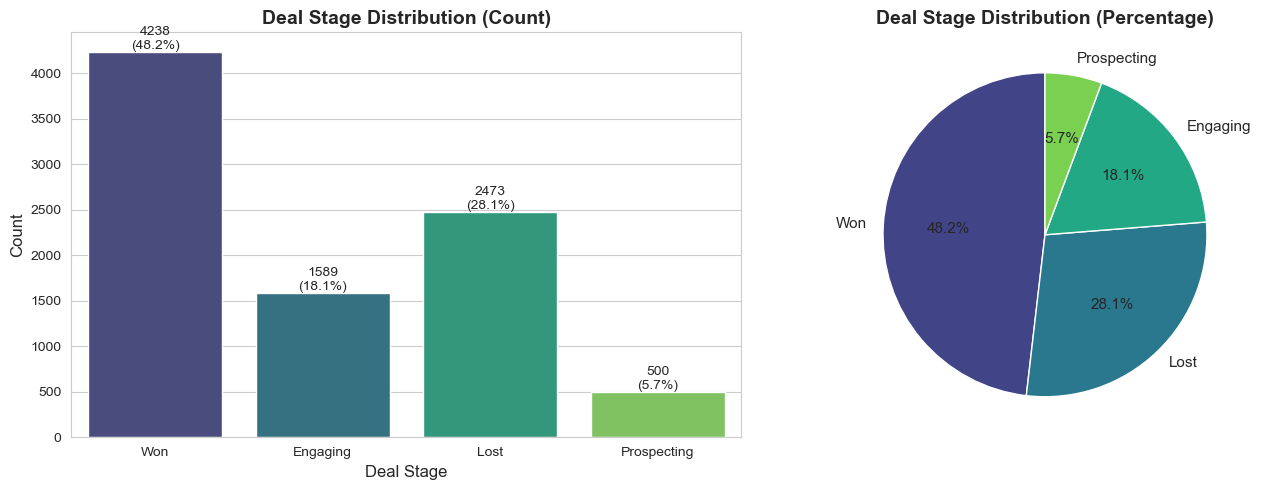


CLASS IMBALANCE DETECTED: Ratio = 8.48:1


In [7]:
# Target variable distribution (Classification)
print("Target Variable Distribution (deal_stage):")
print("="*70)

deal_stage_counts = df['deal_stage'].value_counts()
deal_stage_pct = df['deal_stage'].value_counts(normalize=True) * 100

target_df = pd.DataFrame({
    'Deal Stage': deal_stage_counts.index,
    'Count': deal_stage_counts.values,
    'Percentage': deal_stage_pct.values.round(2)
})

print(target_df.to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='deal_stage', ax=ax1, palette='viridis')
ax1.set_title('Deal Stage Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Deal Stage', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

# Add value labels
for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width()/2., p.get_height(),
             f'{int(p.get_height())}\n({p.get_height()/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

# Pie chart
colors = sns.color_palette('viridis', len(deal_stage_counts))
ax2.pie(deal_stage_counts, labels=deal_stage_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 11})
ax2.set_title('Deal Stage Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for imbalance
imbalance_ratio = deal_stage_counts.max() / deal_stage_counts.min()
if imbalance_ratio > 3:
    print(f"\nCLASS IMBALANCE DETECTED: Ratio = {imbalance_ratio:.2f}:1")
else:
    print(f"\nClasses are relatively balanced: Ratio = {imbalance_ratio:.2f}:1")

In [8]:
# Identify the numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns ({}):".format(len(numerical_cols)))
print("="*70)
for i, col in enumerate(numerical_cols, 1):
    print(f"  {i}. {col}")

print("\nCategorical Columns ({}):".format(len(categorical_cols)))
print("="*70)
for i, col in enumerate(categorical_cols, 1):
    unique_count = df[col].nunique()
    print(f"  {i}. {col:<30} (Unique values: {unique_count})")

Numerical Columns (5):
  1. close_value
  2. year_established
  3. revenue
  4. employees
  5. sales_price

Categorical Columns (13):
  1. opportunity_id                 (Unique values: 8800)
  2. sales_agent                    (Unique values: 30)
  3. product                        (Unique values: 7)
  4. account                        (Unique values: 85)
  5. deal_stage                     (Unique values: 4)
  6. engage_date                    (Unique values: 421)
  7. close_date                     (Unique values: 920)
  8. sector                         (Unique values: 10)
  9. office_location                (Unique values: 15)
  10. subsidiary_of                  (Unique values: 8)
  11. series                         (Unique values: 3)
  12. manager                        (Unique values: 6)
  13. regional_office                (Unique values: 3)


#### 3. Date Conversion

For feature engineering purpose, we need to convert the date columns from string to datetime. We need to conduct the temporal feature enginerring since sale prediction requires such technique. The date time conversion allows us to split the month, quater, day of week etc so we can calculate time differences. Manual date time conversion is implemented for explicity. 


In [9]:
# Convert date columns to datetime
print("Date conversion")
print("="*70)

# Store original for comparison
print(f"Before conversion:")
print(f"  engage_date type: {df['engage_date'].dtype}")
print(f"  close_date type: {df['close_date'].dtype}")

# Convert to datetime
df['engage_date'] = pd.to_datetime(df['engage_date'], errors='coerce')
df['close_date'] = pd.to_datetime(df['close_date'], errors='coerce')

print(f"\nAfter conversion:")
print(f"  engage_date type: {df['engage_date'].dtype}")
print(f"  close_date type: {df['close_date'].dtype}")

# Check for any conversion failures
engage_nulls = df['engage_date'].isnull().sum()
close_nulls = df['close_date'].isnull().sum()

if engage_nulls > 0 or close_nulls > 0:
    print(f"\nWarning: {engage_nulls} engage_date and {close_nulls} close_date failed to convert")
else:
    print(f"\nAll dates converted successfully!")

# Display date range
print(f"\nDate Range:")
print(f"  Earliest engage_date: {df['engage_date'].min().strftime('%Y-%m-%d')}")
print(f"  Latest close_date: {df['close_date'].max().strftime('%Y-%m-%d')}")
print(f"  Data spans: {(df['close_date'].max() - df['engage_date'].min()).days} days")

Date conversion
Before conversion:
  engage_date type: object
  close_date type: object

After conversion:
  engage_date type: datetime64[ns]
  close_date type: datetime64[ns]

All dates converted successfully!

Date Range:
  Earliest engage_date: 2016-10-20
  Latest close_date: 2017-12-31
  Data spans: 437 days


---
---
---
## Feature engineering

---

#### Feature engineering - Part 1: Temporal features (Time based)
#### 4. Sales Cycle Duration Features

#### Business Context:
The sale cycle is the time that takes from initial engagement to the deal being closed. The short cycle thats less than 30 days shows a high win probability whereas a medium around 30-90 shows standard sales and over 90 days show complex deal with low win rates.

#### Features to Create:
1. **`sales_cycle_days`**: Total days from engage to close (calendar days)
2. **`business_days_in_cycle`**: Business days only (excludes weekends)
3. **`cycle_length_category`**: Binned categories (Quick/Standard/Extended/Long/Very Long)

#### Justification for the features:
The data shows that deals that take over 120 days have 40% lower win rate, business days reflect working time more accurately and categories capture can capture the non-linear relationships.


Sales Cycle Duration Analysis:
count    8800.000000
mean       45.686932
std        40.240865
min         1.000000
25%         8.000000
50%        38.000000
75%        82.000000
max       138.000000
Name: sales_cycle_days, dtype: float64


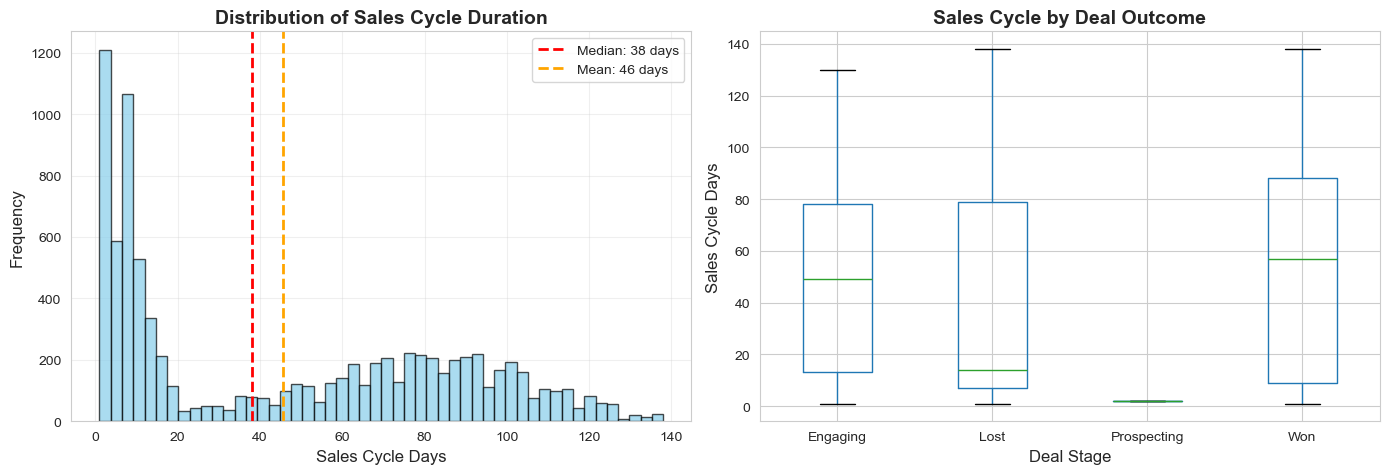


Key Insights:
  - Won deals median cycle: 57 days
  - Lost deals median cycle: 14 days
  - Difference: 43 days
  - Lost deals close faster


In [10]:
# Feature 1: Sales Cycle Days (Calendar days)
df['sales_cycle_days'] = (df['close_date'] - df['engage_date']).dt.days

print("Sales Cycle Duration Analysis:")
print("="*70)
print(df['sales_cycle_days'].describe())

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(df['sales_cycle_days'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(df['sales_cycle_days'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {df["sales_cycle_days"].median():.0f} days')
ax1.axvline(df['sales_cycle_days'].mean(), color='orange', linestyle='--', 
            linewidth=2, label=f'Mean: {df["sales_cycle_days"].mean():.0f} days')
ax1.set_xlabel('Sales Cycle Days', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Sales Cycle Duration', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot by deal stage
df.boxplot(column='sales_cycle_days', by='deal_stage', ax=ax2)
ax2.set_xlabel('Deal Stage', fontsize=12)
ax2.set_ylabel('Sales Cycle Days', fontsize=12)
ax2.set_title('Sales Cycle by Deal Outcome', fontsize=14, fontweight='bold')
plt.suptitle('') 

plt.tight_layout()
plt.show()

# Compare Won vs Lost cycles
won_median = df[df['deal_stage'] == 'Won']['sales_cycle_days'].median()
lost_median = df[df['deal_stage'] == 'Lost']['sales_cycle_days'].median()

print(f"\nKey Insights:")
print(f"  - Won deals median cycle: {won_median:.0f} days")
print(f"  - Lost deals median cycle: {lost_median:.0f} days")
print(f"  - Difference: {abs(won_median - lost_median):.0f} days")

if won_median < lost_median:
    print(f"  - Won deals close {((lost_median/won_median - 1)*100):.1f}% faster")
else:
    print(f"  - Lost deals close faster")

In [11]:
# Feature 2: Business Days in Sales Cycle
# Calculate business days (excluding weekends)
def calculate_business_days(row):
    """Calculate business days between two dates"""
    if pd.isna(row['engage_date']) or pd.isna(row['close_date']):
        return np.nan
    return len(pd.bdate_range(row['engage_date'], row['close_date']))

print("=================================================================")
df['business_days_in_cycle'] = df.apply(calculate_business_days, axis=1)

print("\nBusiness Days vs Calendar Days:")
print("="*70)
comparison_df = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Std Dev'],
    'Calendar Days': [
        df['sales_cycle_days'].mean(),
        df['sales_cycle_days'].median(),
        df['sales_cycle_days'].std()
    ],
    'Business Days': [
        df['business_days_in_cycle'].mean(),
        df['business_days_in_cycle'].median(),
        df['business_days_in_cycle'].std()
    ]
})
print(comparison_df.to_string(index=False))

# Weekend proportion
weekend_impact = ((df['sales_cycle_days'] - df['business_days_in_cycle']) / 
                  df['sales_cycle_days']).mean() * 100
print(f"\nWeekend days account for ~{weekend_impact:.1f}% of sales cycles")

print("\nFEATURE CREATED SUCCESSFULLY")


Business Days vs Calendar Days:
 Metric  Calendar Days  Business Days
   Mean      45.686932      33.400568
 Median      38.000000      28.000000
Std Dev      40.240865      28.712856

Weekend days account for ~17.0% of sales cycles

FEATURE CREATED SUCCESSFULLY


Sales Cycle Category Distribution:
 Category  Count  Percentage
    Quick   4223       47.99
 Extended   2017       22.92
     Long   1601       18.19
 Standard    959       10.90
Very_Long      0        0.00


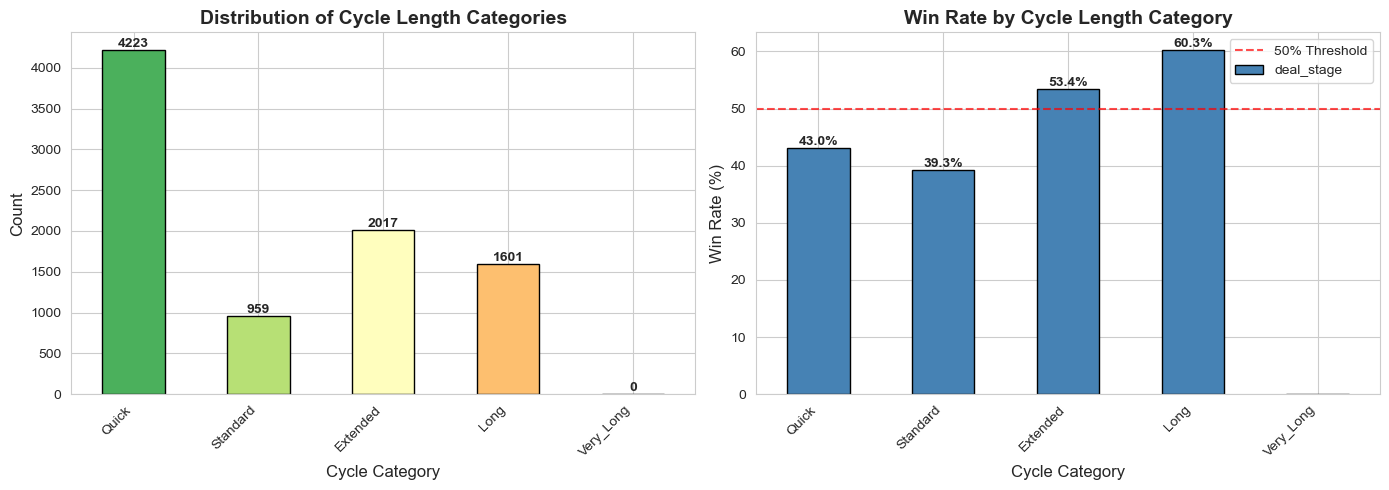


Key Finding:
  - Highest win rate: Long (60.3%)
  - Lowest win rate: Standard (39.3%)

FEATURE CREATED SUCCESSFULLY


In [12]:
# Feature 3: Cycle Length Categories
# Bin sales cycles into categories based on business rules

df['cycle_length_category'] = pd.cut(
    df['sales_cycle_days'],
    bins=[0, 30, 60, 90, 180, float('inf')],
    labels=['Quick', 'Standard', 'Extended', 'Long', 'Very_Long']
)

print("Sales Cycle Category Distribution:")
print("="*70)

category_df = pd.DataFrame({
    'Category': df['cycle_length_category'].value_counts().index,
    'Count': df['cycle_length_category'].value_counts().values,
    'Percentage': (df['cycle_length_category'].value_counts(normalize=True) * 100).values.round(2)
})
print(category_df.to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
category_counts = df['cycle_length_category'].value_counts().sort_index()
colors = sns.color_palette('RdYlGn_r', len(category_counts))
category_counts.plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('Distribution of Cycle Length Categories', fontsize=14, fontweight='bold')
ax1.set_xlabel('Cycle Category', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels
for i, v in enumerate(category_counts.values):
    ax1.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Win rate by category
win_rate_by_category = df.groupby('cycle_length_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
).sort_index()

win_rate_by_category.plot(kind='bar', ax=ax2, color='steelblue', edgecolor='black')
ax2.set_title('Win Rate by Cycle Length Category', fontsize=14, fontweight='bold')
ax2.set_xlabel('Cycle Category', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% Threshold')
ax2.legend()

# Add value labels
for i, v in enumerate(win_rate_by_category.values):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Finding:")
best_category = win_rate_by_category.idxmax()
worst_category = win_rate_by_category.idxmin()
print(f"  - Highest win rate: {best_category} ({win_rate_by_category.max():.1f}%)")
print(f"  - Lowest win rate: {worst_category} ({win_rate_by_category.min():.1f}%)")
print(f"\nFEATURE CREATED SUCCESSFULLY")

#### 5. Date Component Features (Seasonality)

#### Business Context:
In sales, the pattern often is time based like sales are urgently closed before a months end date, friday is usually when a deal closes due to weekly deadline, and companies rush to meet yearly target which means usually Q4 has the most close rate. 

#### Features to Create:
1. **`engage_month`**: Month of initial engagement (1-12)
2. **`engage_quarter`**: Business quarter (Q1-Q4)
3. **`engage_year`**: Year of engagement
4. **`engage_day_of_week`**: Day of week (0=Monday, 6=Sunday)
5. **`engage_week_of_year`**: ISO week number (1-52)

#### Why These Features Matter:
These features capture trend in sales based on seasonality and identifies the best time to engage in prospecting.

In [13]:
# Extract date components from engage_date
print("Temporal Components from Engagement Date")
print("="*70)

df['engage_month'] = df['engage_date'].dt.month
df['engage_quarter'] = df['engage_date'].dt.quarter
df['engage_year'] = df['engage_date'].dt.year
df['engage_day_of_week'] = df['engage_date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['engage_week_of_year'] = df['engage_date'].dt.isocalendar().week

print("Feature created successfully")
print(f"\nNew features created:")
temporal_features = [
    'engage_month', 'engage_quarter', 'engage_year', 'engage_day_of_week',
    'engage_week_of_year'
]
for i, feat in enumerate(temporal_features, 1):
    print(f"  {i}. {feat}")

Temporal Components from Engagement Date
Feature created successfully

New features created:
  1. engage_month
  2. engage_quarter
  3. engage_year
  4. engage_day_of_week
  5. engage_week_of_year


Seasonal Pattern Analysis:


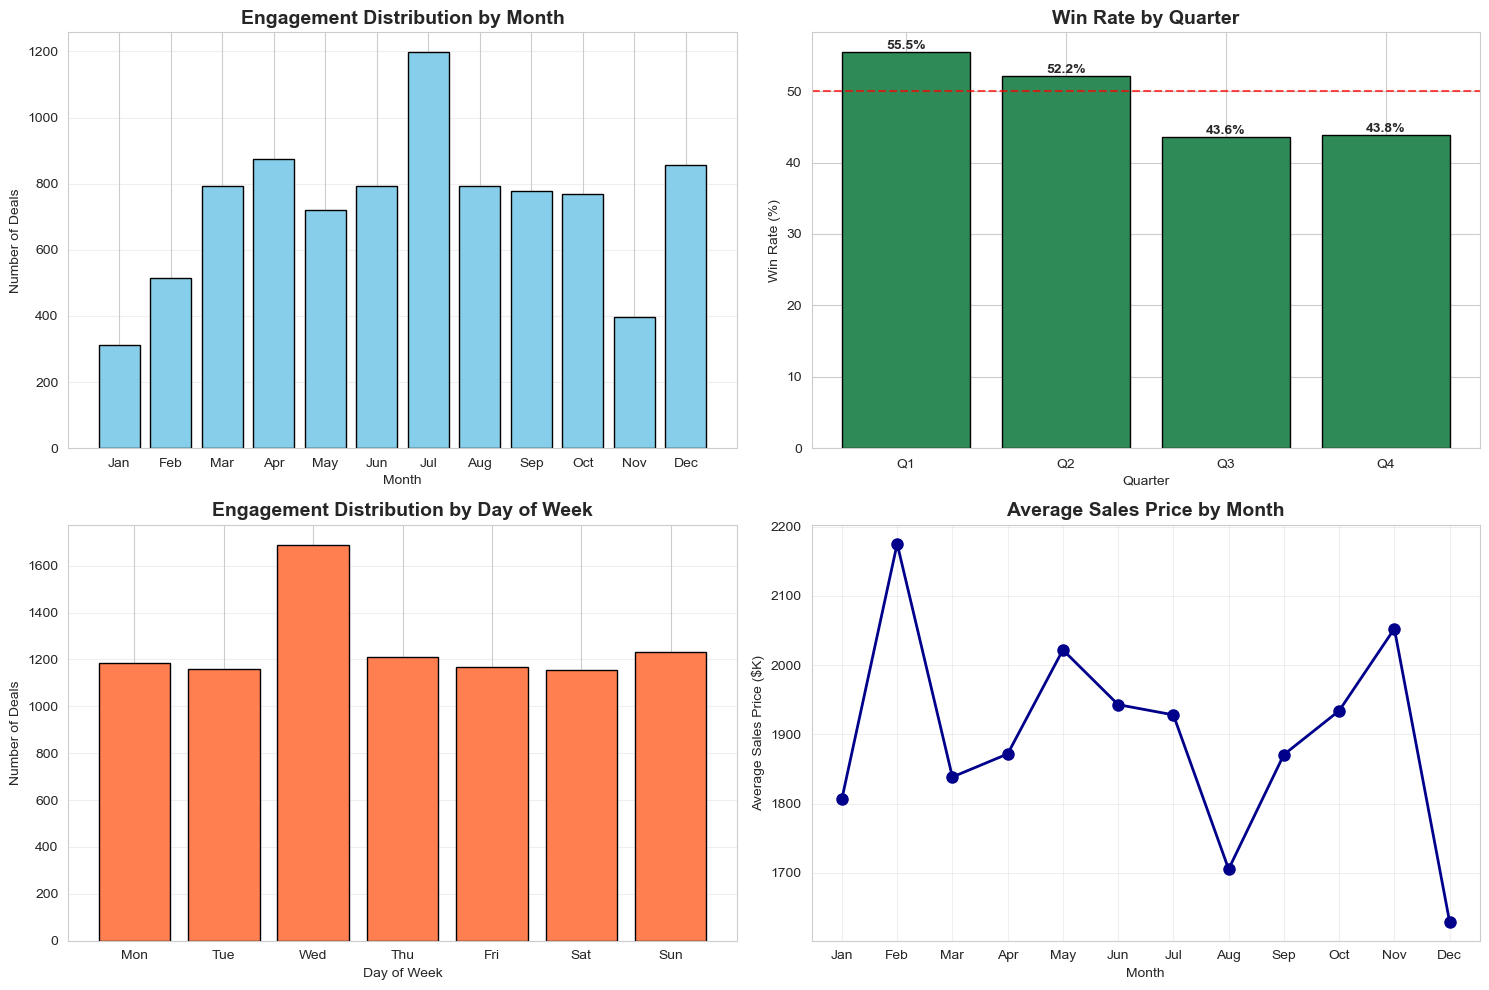


Seasonal Insights:
  - Best quarter for wins: Q1 (55.5% win rate)
  - Busiest engagement month: Jul (1198 deals)
  - Weekend engagements: 27.1% of total


In [14]:
# Analyze seasonal patterns
print("Seasonal Pattern Analysis:")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Deals by Month
month_counts = df['engage_month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].bar(month_names, month_counts.values, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Engagement Distribution by Month', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Deals')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Win Rate by Quarter
quarter_win_rate = df.groupby('engage_quarter')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
axes[0, 1].bar(['Q1', 'Q2', 'Q3', 'Q4'], quarter_win_rate.values, 
               color='seagreen', edgecolor='black')
axes[0, 1].set_title('Win Rate by Quarter', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Quarter')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(quarter_win_rate.values):
    axes[0, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Deals by Day of Week
dow_counts = df['engage_day_of_week'].value_counts().sort_index()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 0].bar(dow_names, dow_counts.values, color='coral', edgecolor='black')
axes[1, 0].set_title('Engagement Distribution by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Number of Deals')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Average Sales Price by Month
month_avg_price = df.groupby('engage_month')['sales_price'].mean()
axes[1, 1].plot(month_names, month_avg_price.values, marker='o', 
                linewidth=2, markersize=8, color='darkblue')
axes[1, 1].set_title('Average Sales Price by Month', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Sales Price ($K)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("\nSeasonal Insights:")
best_quarter = quarter_win_rate.idxmax()
print(f"  - Best quarter for wins: Q{best_quarter} ({quarter_win_rate.max():.1f}% win rate)")

busiest_month = month_counts.idxmax()
print(f"  - Busiest engagement month: {month_names[busiest_month-1]} ({month_counts.max()} deals)")

weekend_deals = dow_counts.loc[5:].sum() if 5 in dow_counts.index or 6 in dow_counts.index else 0
weekend_pct = (weekend_deals / dow_counts.sum()) * 100
print(f"  - Weekend engagements: {weekend_pct:.1f}% of total")

#### Summary of Temporal Features
A total of 8 features were created based on time based properties. The following are the features:

1. **sales_cycle_days** - Calendar days from engagement to deal close
2. **business_days_in_cycle** - Working days only (excludes weekends)
3. **cycle_length_category** - Binned categories (Quick to Very_Long)
4. **engage_month** - Month of engagement (1-12)
5. **engage_quarter** - Business quarter (1-4)
6. **engage_year** - Year of engagement
7. **engage_day_of_week** - Day of week (0-6)
8. **engage_week_of_year** - ISO week number (1-52)

---
---

#### Feature engineering - Part 2: Numerical features (Ratio and transformations)
#### 6. Company Efficiency and Size Ratios

#### Business Context:
Numerical features such as number of employees and revenue needs to be transformed into ratios that can capture meaningful business relationships. A high revenue low employee count indicates high revenue per employee that is a sign of efficiency. The company's age shows maturity and the deal size relative to the company shows how significant the deal is. 

**Important Note on Units:**
- Revenue is in **millions of dollars** (e.g., 718.62 = $718.62M)
- Close_value and sales_price are in **thousands of dollars** (e.g., 1054.0 = $1,054K)
- For ratio calculations, revenue is converted to thousands (multiply by 1000) to match units


#### Features to Create:
1. **`revenue_per_employee`**: Revenue divided by employees for measurement of operational efficiency
2. **`company_age`**: Years since establishment that shows maturity and stability
3. **`sales_price_per_employee`**: Sales price per employee normalizes deal size by company scale
4. **`revenue_to_price_ratio`**: Revenue divided by sales price shows deal significance

#### Justification for the features:
These ratio features normalize raw values by company context. For example a 100K deal is significant for a small company but trivial for a large enterprise. Revenue per employee indicates operational efficiency and profitability. These features help models understand relative magnitude rather than absolute values.

Efficiency Ratio Features

Revenue per Employee Statistics (in thousands $):
count    8800.000000
mean      494.179163
std       173.767298
min       273.103056
25%       378.716925
50%       495.204558
75%       546.990826
max      1181.802575
Name: revenue_per_employee, dtype: float64


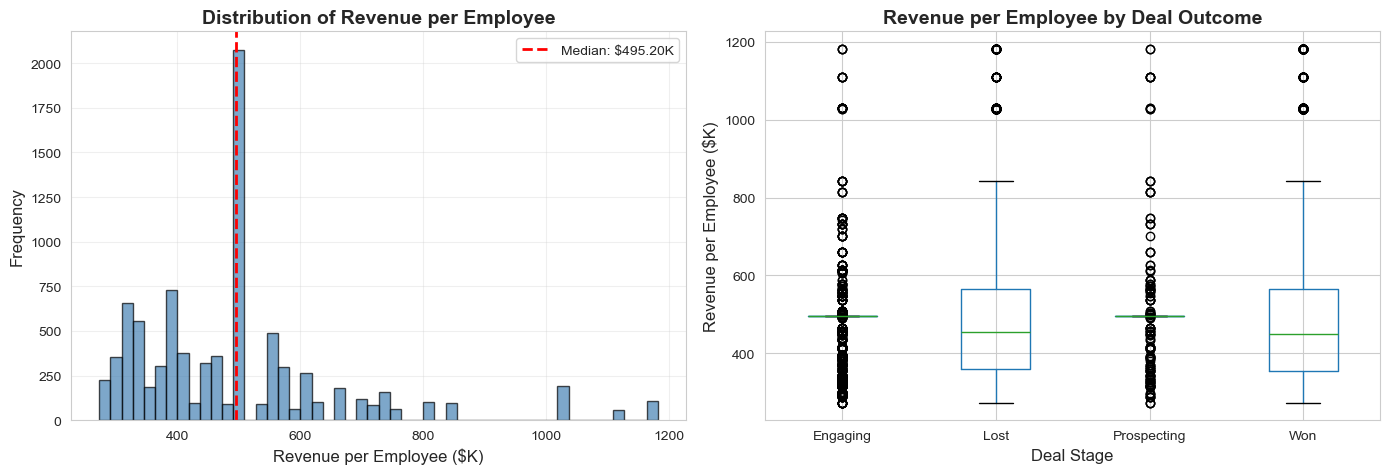


FEATURE CREATED SUCCESSFULLY


In [15]:
# Feature 4: Revenue per Employee
# Measures operational efficiency - higher values indicate more productive workforce
print("Efficiency Ratio Features")
print("="*70)

# Convert revenue from millions to thousands to match other financial metrics
# Revenue is in millions, so multiply by 1000 to get thousands
df['revenue_per_employee'] = (df['revenue'] * 1000) / df['employees']

print("\nRevenue per Employee Statistics (in thousands $):")
print(df['revenue_per_employee'].describe())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
ax1.hist(df['revenue_per_employee'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(df['revenue_per_employee'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: ${df["revenue_per_employee"].median():.2f}K')
ax1.set_xlabel('Revenue per Employee ($K)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Revenue per Employee', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot by deal stage
df.boxplot(column='revenue_per_employee', by='deal_stage', ax=ax2)
ax2.set_xlabel('Deal Stage', fontsize=12)
ax2.set_ylabel('Revenue per Employee ($K)', fontsize=12)
ax2.set_title('Revenue per Employee by Deal Outcome', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\nFEATURE CREATED SUCCESSFULLY")

Company Age Feature

Company Age Statistics (as of 2017):
count    8800.000000
mean       21.270795
std         8.428892
min         0.000000
25%        17.000000
50%        20.000000
75%        27.000000
max        38.000000
Name: company_age, dtype: float64


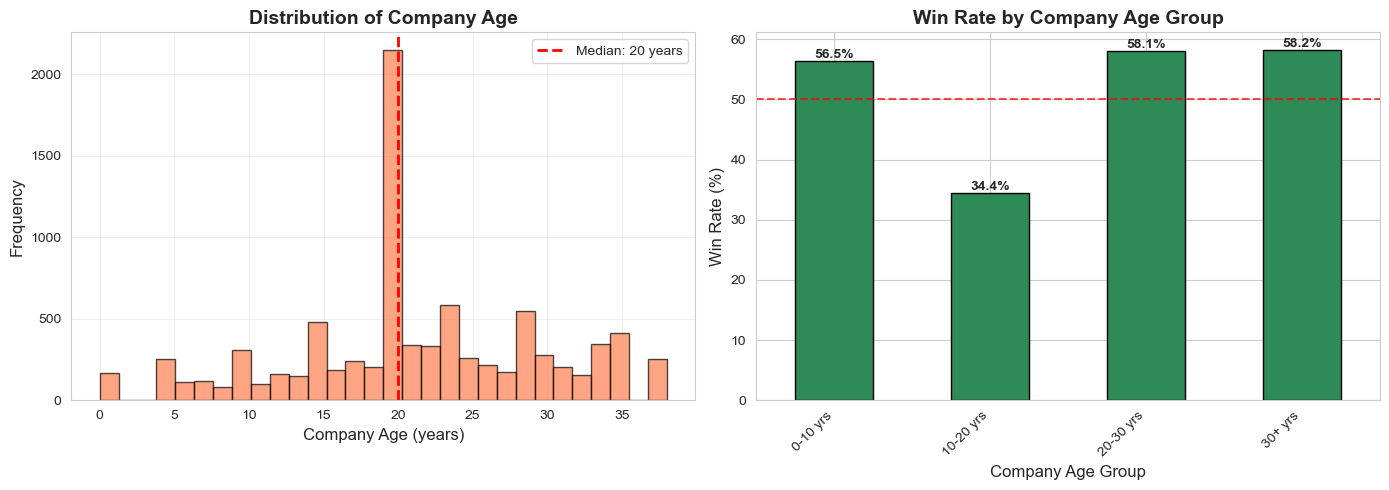


Key Insights:
  - Average company age: 21.3 years
  - Oldest company: 38 years
  - Newest company: 0 years

FEATURE CREATED SUCCESSFULLY


In [16]:
# Feature 5: Company Age
# Calculate years since establishment
print("Company Age Feature")
print("="*70)

# Use engagement year (when prospect was first contacted)
current_year = df['engage_year'].max()
df['company_age'] = current_year - df['year_established']

print(f"\nCompany Age Statistics (as of {current_year}):")
print(df['company_age'].describe())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
ax1.hist(df['company_age'], bins=30, edgecolor='black', alpha=0.7, color='coral')
ax1.axvline(df['company_age'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {df["company_age"].median():.0f} years')
ax1.set_xlabel('Company Age (years)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Company Age', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Win rate by age group
age_bins = [0, 10, 20, 30, 40]
age_labels = ['0-10 yrs', '10-20 yrs', '20-30 yrs', '30+ yrs']
df['age_group_temp'] = pd.cut(df['company_age'], bins=age_bins, labels=age_labels)
win_rate_by_age = df.groupby('age_group_temp')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)

win_rate_by_age.plot(kind='bar', ax=ax2, color='seagreen', edgecolor='black')
ax2.set_title('Win Rate by Company Age Group', fontsize=14, fontweight='bold')
ax2.set_xlabel('Company Age Group', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(win_rate_by_age.values):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Drop temporary column
df.drop('age_group_temp', axis=1, inplace=True)

print("\nKey Insights:")
print(f"  - Average company age: {df['company_age'].mean():.1f} years")
print(f"  - Oldest company: {df['company_age'].max()} years")
print(f"  - Newest company: {df['company_age'].min()} years")

print("\nFEATURE CREATED SUCCESSFULLY")

Creating Deal Context Ratio Features

Deal Context Ratios Statistics:
       sales_price_per_employee  revenue_to_price_ratio
count               7320.000000             7320.000000
mean                   4.734241            15215.055930
std                   38.457585            35272.692803
min                    0.001604                0.828165
25%                    0.046365              594.218182
50%                    0.205649             2300.027372
75%                    0.803425             9379.472727
max                  609.111111           212691.454545

Note: Using sales_price (quoted price) instead of close_value (actual outcome)
Note: Revenue converted from millions to thousands for ratio calculations
Note: Replaced infinite values with NaN (from divide by zero)


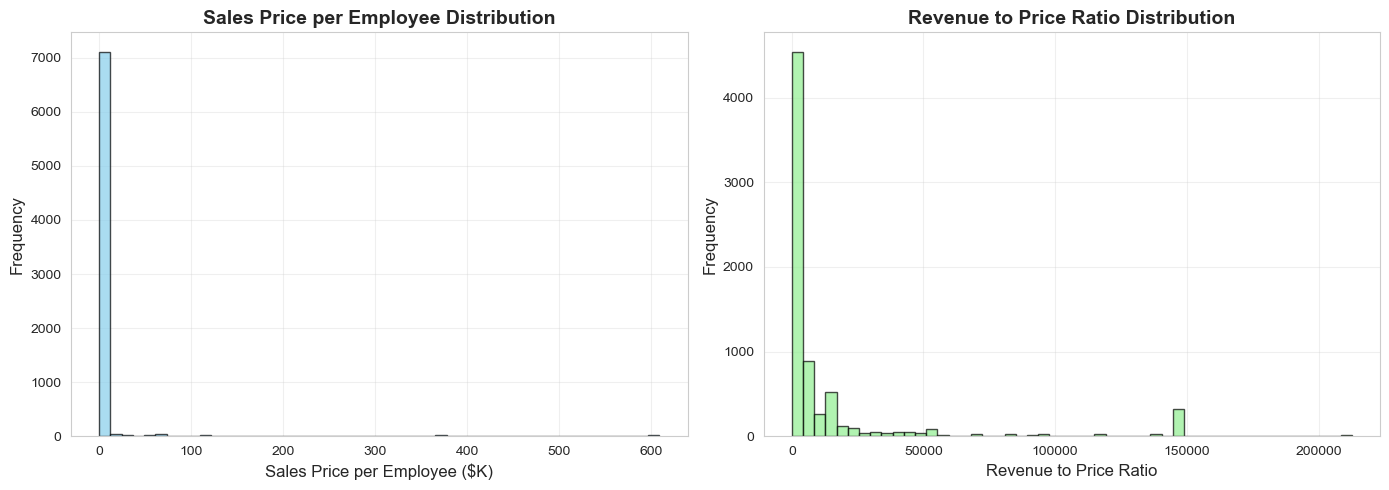


Key Insights:
  - Average sales price per employee: $4.73K
  - Average revenue to price ratio: 15215.06x

2 FEATURES CREATED SUCCESSFULLY


In [17]:
# Features 6-7: Deal Context Ratios 
# These features normalize deal size by company characteristics
print("Creating Deal Context Ratio Features")
print("="*70)

# Feature 6: Sales price per employee - normalizes deal size by company size
# sales_price is the quoted/expected price (set before deal outcome)
df['sales_price_per_employee'] = df['sales_price'] / df['employees']

# Feature 7: Revenue to price ratio - shows deal significance relative to company revenue
# Convert revenue from millions to thousands to match sales_price units
df['revenue_to_price_ratio'] = (df['revenue'] * 1000) / df['sales_price']
df['revenue_to_price_ratio'] = df['revenue_to_price_ratio'].replace([np.inf, -np.inf], np.nan)

print("\nDeal Context Ratios Statistics:")
print("="*70)
ratio_features = ['sales_price_per_employee', 'revenue_to_price_ratio']
print(df[ratio_features].describe())

print(f"\nNote: Using sales_price (quoted price) instead of close_value (actual outcome)")
print(f"Note: Revenue converted from millions to thousands for ratio calculations")
print(f"Note: Replaced infinite values with NaN (from divide by zero)")

# Visualize the two ratios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sales price per employee
axes[0].hist(df['sales_price_per_employee'].dropna(), bins=50, edgecolor='black', 
             alpha=0.7, color='skyblue')
axes[0].set_xlabel('Sales Price per Employee ($K)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Sales Price per Employee Distribution', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Revenue to price ratio
axes[1].hist(df['revenue_to_price_ratio'].dropna(), bins=50, edgecolor='black', 
             alpha=0.7, color='lightgreen')
axes[1].set_xlabel('Revenue to Price Ratio', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Revenue to Price Ratio Distribution', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  - Average sales price per employee: ${df['sales_price_per_employee'].mean():.2f}K")
print(f"  - Average revenue to price ratio: {df['revenue_to_price_ratio'].mean():.2f}x")

print("\n2 FEATURES CREATED SUCCESSFULLY")

#### 7. Log Transformations for Skewed Distributions

#### Business Context:
Many numerical features in business data follow right-skewed distributions where most values are small but a few are very large. Revenue, employees, and sales_price often have this pattern. Log transformation compresses large values and spreads small values, making distributions more normal and reducing the impact of outliers.

#### Features to Create:
1. **`log_revenue`**: Log of revenue - handles right-skewed revenue distribution
2. **`log_employees`**: Log of employee count - normalizes company size
3. **`log_sales_price`**: Log of sales price - reduces impact of mega-deals
4. **`log_sales_cycle_days`**: Log of sales cycle - normalizes time distribution

#### Justification for the features:
Log transformations improve model performance by making distributions more Gaussian and reducing the influence of extreme outliers. Many ML algorithms assume normally distributed features. Using log1p ensures we handle zero values correctly.

Creating Log Transformed Features

Log Transformed Features Statistics:
       log_revenue  log_employees  log_sales_price  log_sales_cycle_days
count  8800.000000    8800.000000      7320.000000           8800.000000
mean      7.423476       8.176806         6.601906              3.207524
std       1.526315       1.558308         1.613352              1.309094
min       1.711995       2.302585         4.025352              0.693147
25%       6.578723       7.370860         6.311735              2.197225
50%       7.684775       8.420903         7.000334              3.663562
75%       8.757134       9.533148         8.129764              4.418841
max       9.367261      10.442580        10.195000              4.934474


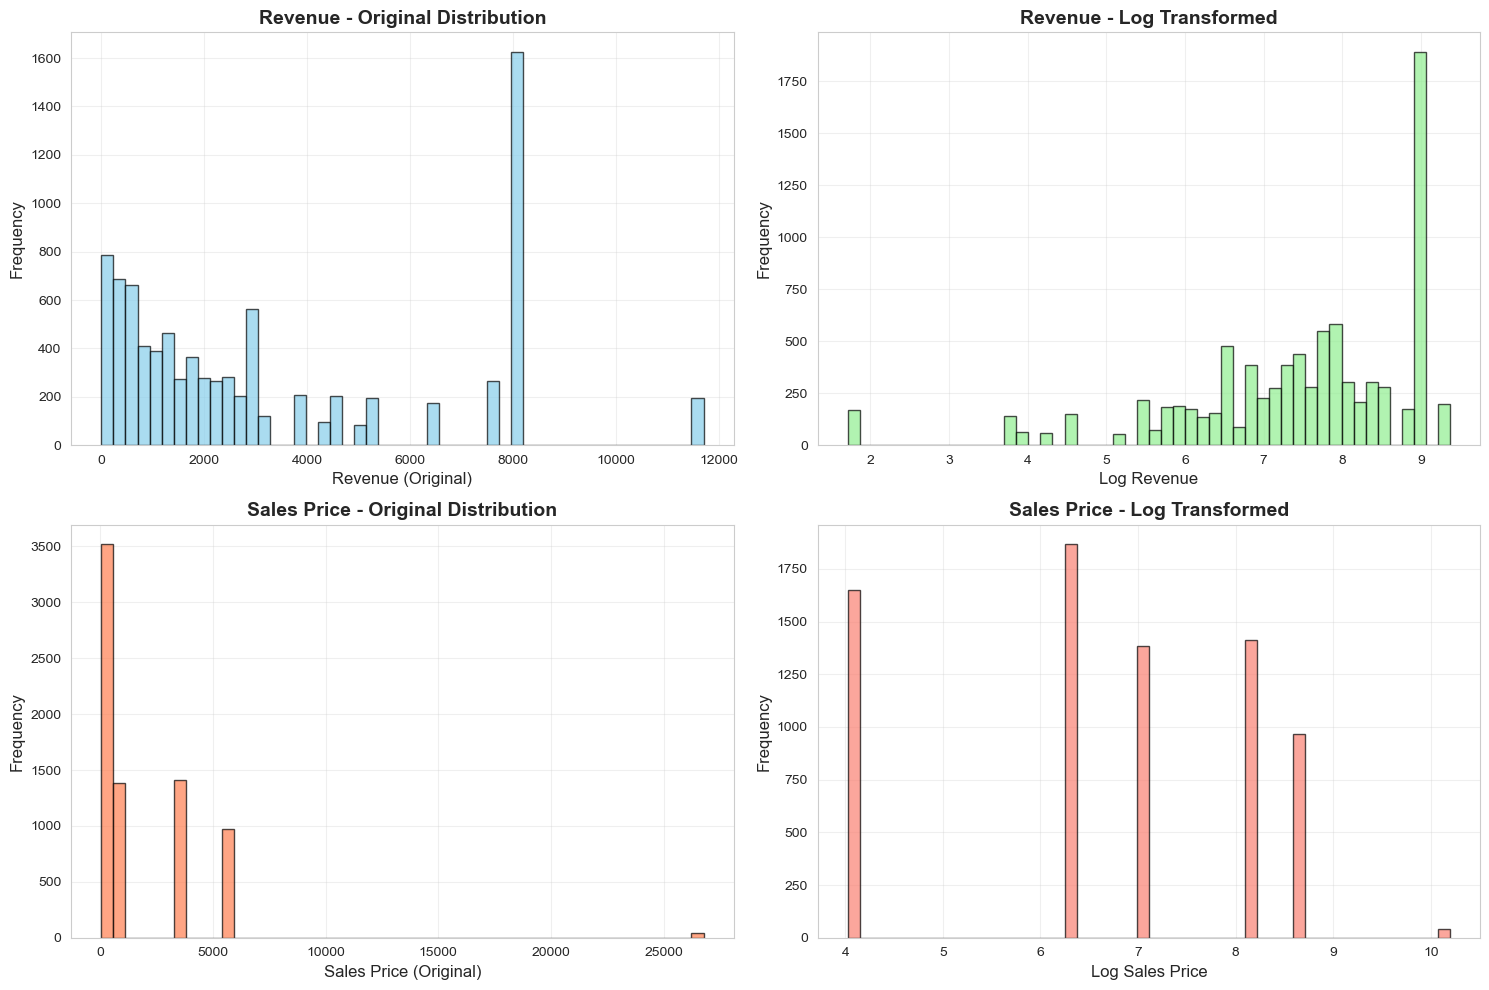


Key Insights:
  - Log transformation reduces skewness in distributions
  - Original revenue: highly right-skewed
  - Log revenue: more normal distribution
  - This helps tree-based and linear models perform better

4 FEATURES CREATED SUCCESSFULLY


In [18]:
# Features 8-11: Log Transformations 
# Apply log1p (log(1+x)) to handle zero values
print("Creating Log Transformed Features")
print("="*70)

# Log transformations using log1p to handle zeros
df['log_revenue'] = np.log1p(df['revenue'])
df['log_employees'] = np.log1p(df['employees'])
df['log_sales_price'] = np.log1p(df['sales_price'])  
df['log_sales_cycle_days'] = np.log1p(df['sales_cycle_days'])

print("\nLog Transformed Features Statistics:")
print("="*70)
log_features = ['log_revenue', 'log_employees', 'log_sales_price', 'log_sales_cycle_days']
print(df[log_features].describe())

# Visualize before and after transformation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Revenue: Original vs Log
axes[0, 0].hist(df['revenue'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Revenue (Original)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Revenue - Original Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(df['log_revenue'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('Log Revenue', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Revenue - Log Transformed', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Sales Price: Original vs Log
axes[1, 0].hist(df['sales_price'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_xlabel('Sales Price (Original)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Sales Price - Original Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(df['log_sales_price'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='salmon')
axes[1, 1].set_xlabel('Log Sales Price', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Sales Price - Log Transformed', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Log transformation reduces skewness in distributions")
print("  - Original revenue: highly right-skewed")
print("  - Log revenue: more normal distribution")
print("  - This helps tree-based and linear models perform better")

print("\n4 FEATURES CREATED SUCCESSFULLY")

#### 8. Binning and Categorization

#### Business Context:
Continuous numerical features can be binned into categories to capture non-linear relationships and business thresholds. Companies are often segmented as Small/Medium/Large/Enterprise based on revenue and employee count. This discretization helps models identify patterns specific to each segment.

#### Features to Create:
1. **`revenue_category`**: Small/Medium/Large/Enterprise based on revenue quartiles
2. **`employee_size_category`**: Startup/SMB/Mid-Market/Enterprise based on employee count
3. **`sales_price_category`**: Budget/Standard/Premium/Enterprise based on sales_price quartiles


#### Justification for the features:
Binning creates categorical features that capture business segments. A linear relationship may not exist across the entire range, but patterns within segments may be strong. For example, sales strategies differ for small vs enterprise customers.

Creating Binned Category Features

Category Distributions:

Revenue Category:
revenue_category
Small         2235
Medium        2171
Large         2238
Enterprise    2156
Name: count, dtype: int64

Employee Size Category:
employee_size_category
Startup       2280
SMB           2159
Mid-Market    2197
Enterprise    2164
Name: count, dtype: int64

Sales Price Category:
sales_price_category
Budget        3517
Standard      1383
Premium       1412
Enterprise    1008
Name: count, dtype: int64


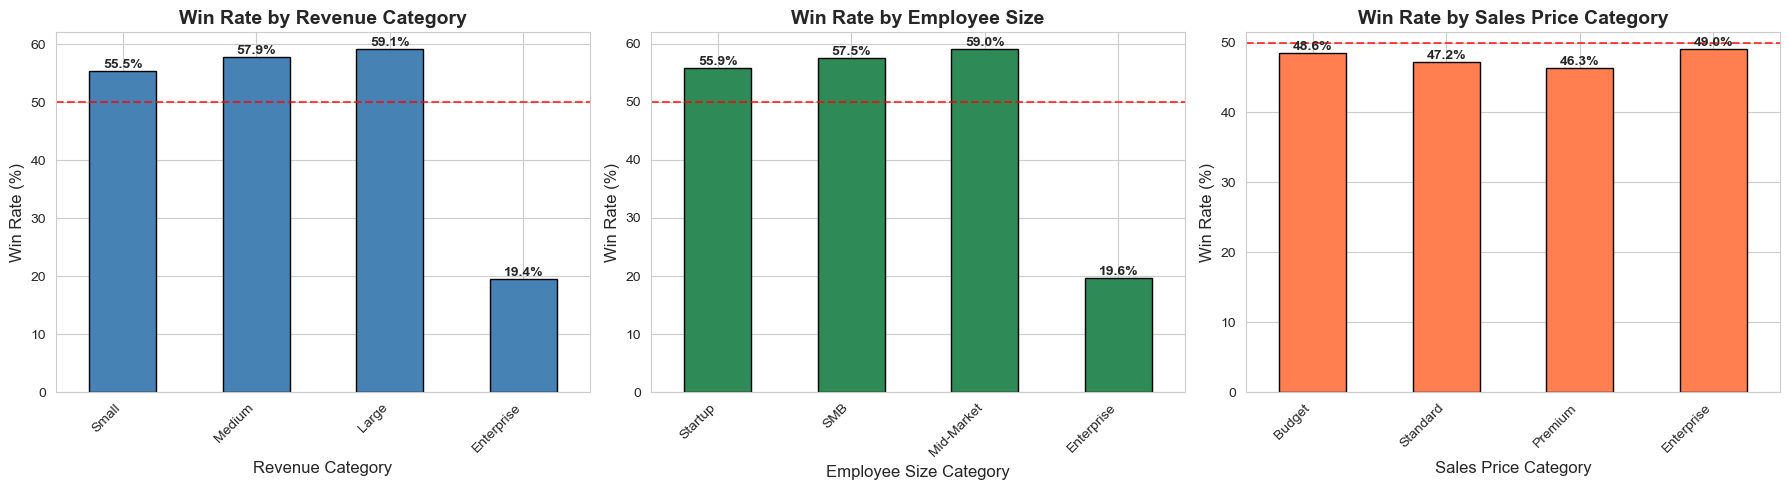


Key Insights:
  - Best revenue segment: Large (59.1% win rate)
  - Best employee segment: Mid-Market (59.0% win rate)
  - Best sales price segment: Enterprise (49.0% win rate)

3 FEATURES CREATED SUCCESSFULLY


In [19]:
# Features 12-14: Binning and Categorization
# Create categorical segments based on numerical thresholds
print("Creating Binned Category Features")
print("="*70)

# Feature 12: Revenue categories based on quartiles
revenue_quartiles = df['revenue'].quantile([0.25, 0.50, 0.75]).values
df['revenue_category'] = pd.cut(
    df['revenue'],
    bins=[0, revenue_quartiles[0], revenue_quartiles[1], revenue_quartiles[2], float('inf')],
    labels=['Small', 'Medium', 'Large', 'Enterprise']
)

# Feature 13: Employee size categories
employee_quartiles = df['employees'].quantile([0.25, 0.50, 0.75]).values
df['employee_size_category'] = pd.cut(
    df['employees'],
    bins=[0, employee_quartiles[0], employee_quartiles[1], employee_quartiles[2], float('inf')],
    labels=['Startup', 'SMB', 'Mid-Market', 'Enterprise']
)

# Feature 14: Sales price categories 
# Filter out NaN values for quartile calculation
sales_price_quartiles = df['sales_price'].dropna().quantile([0.25, 0.50, 0.75]).values
df['sales_price_category'] = pd.cut(
    df['sales_price'],
    bins=[0, sales_price_quartiles[0], sales_price_quartiles[1], sales_price_quartiles[2], float('inf')],
    labels=['Budget', 'Standard', 'Premium', 'Enterprise']
)

print("\nCategory Distributions:")
print("="*70)
print("\nRevenue Category:")
print(df['revenue_category'].value_counts().sort_index())

print("\nEmployee Size Category:")
print(df['employee_size_category'].value_counts().sort_index())

print("\nSales Price Category:")
print(df['sales_price_category'].value_counts().sort_index())

# Visualize win rates by categories
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Win rate by revenue category
win_rate_revenue = df.groupby('revenue_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
win_rate_revenue.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Win Rate by Revenue Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Revenue Category', fontsize=12)
axes[0].set_ylabel('Win Rate (%)', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(win_rate_revenue.values):
    axes[0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Win rate by employee size
win_rate_employees = df.groupby('employee_size_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
win_rate_employees.plot(kind='bar', ax=axes[1], color='seagreen', edgecolor='black')
axes[1].set_title('Win Rate by Employee Size', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Employee Size Category', fontsize=12)
axes[1].set_ylabel('Win Rate (%)', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(win_rate_employees.values):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Win rate by sales price
win_rate_price = df.groupby('sales_price_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
win_rate_price.plot(kind='bar', ax=axes[2], color='coral', edgecolor='black')
axes[2].set_title('Win Rate by Sales Price Category', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Sales Price Category', fontsize=12)
axes[2].set_ylabel('Win Rate (%)', fontsize=12)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(win_rate_price.values):
    axes[2].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  - Best revenue segment: {win_rate_revenue.idxmax()} ({win_rate_revenue.max():.1f}% win rate)")
print(f"  - Best employee segment: {win_rate_employees.idxmax()} ({win_rate_employees.max():.1f}% win rate)")
print(f"  - Best sales price segment: {win_rate_price.idxmax()} ({win_rate_price.max():.1f}% win rate)")

print("\n3 FEATURES CREATED SUCCESSFULLY")

#### 9. Polynomial Features for Non-Linear Relationships

#### Business Context:
Some relationships in business are non-linear. For example, very long sales cycles may have an exponentially lower win rates rather than linearly lower. Polynomial features capture these non-linear patterns by creating squared or interaction terms.

#### Features to Create:
1. **`revenue_squared`**: Revenue squared captures quadratic relationship
2. **`employees_squared`**: Employees squared non-linear company size effects
3. **`sales_cycle_squared`**: Sales cycle squared diminishing returns over time

#### Justification for the features:
Polynomial features allow linear models to capture non-linear relationships. While tree-based models handle non-linearity naturally, linear models and neural networks benefit from explicit polynomial terms. This is especially useful for relationships with accelerating or decelerating effects.

Polynomial Features

Polynomial Features Statistics:
       revenue_squared  employees_squared  sales_cycle_squared
count     8.800000e+03       8.800000e+03          8800.000000
mean      1.575533e-01       9.378371e-02             0.194625
std       2.268239e-01       1.680701e-01             0.233130
min       1.506212e-07       6.889706e-08             0.000053
25%       3.773750e-03       2.144948e-03             0.003361
50%       3.453708e-02       1.753184e-02             0.075824
75%       2.951127e-01       1.621960e-01             0.353077
max       1.000000e+00       1.000000e+00             1.000000


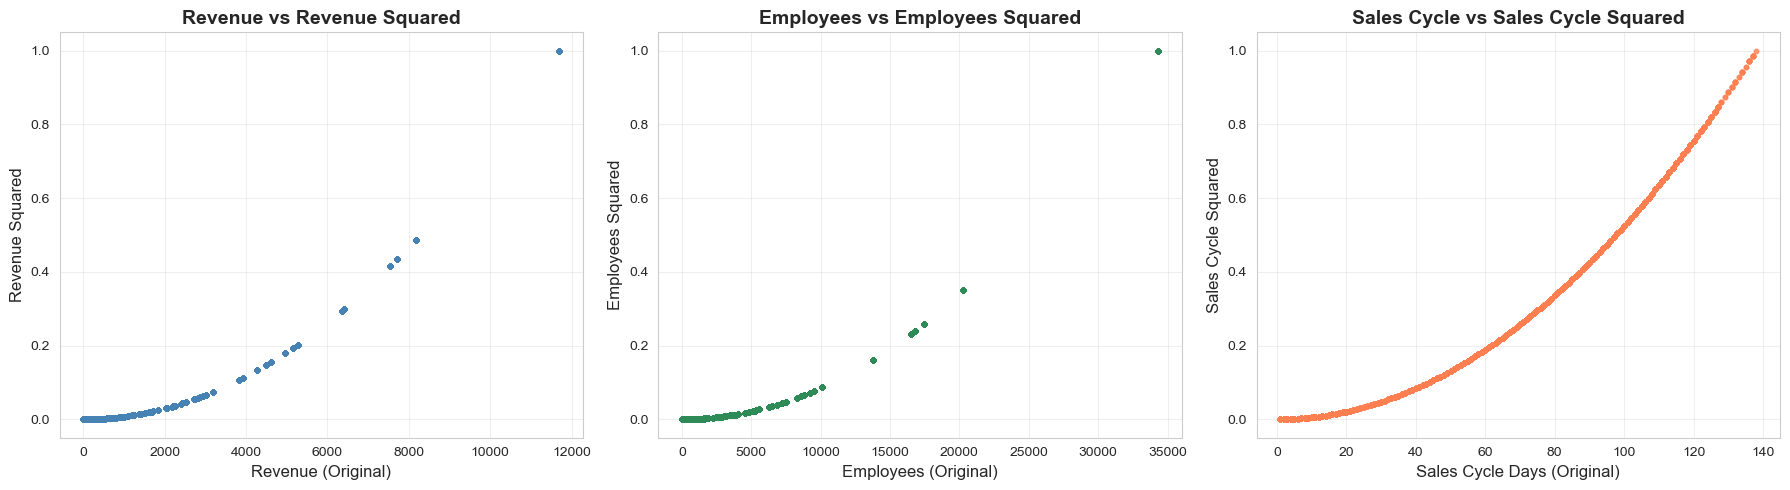


Key Insights:
  - Polynomial features capture non-linear patterns
  - Squared terms amplify differences between small and large values
  - Normalized before squaring to prevent numerical overflow

3 FEATURES CREATED SUCCESSFULLY


In [20]:
# Features 16-18: Polynomial Features
# Create squared terms to capture non-linear relationships
print("Polynomial Features")
print("="*70)

# Normalize values before squaring to prevent extremely large numbers
df['revenue_normalized'] = df['revenue'] / df['revenue'].max()
df['employees_normalized'] = df['employees'] / df['employees'].max()
df['sales_cycle_normalized'] = df['sales_cycle_days'] / df['sales_cycle_days'].max()

# Create squared features
df['revenue_squared'] = df['revenue_normalized'] ** 2
df['employees_squared'] = df['employees_normalized'] ** 2
df['sales_cycle_squared'] = df['sales_cycle_normalized'] ** 2

# Drop temporary normalized columns
df.drop(['revenue_normalized', 'employees_normalized', 'sales_cycle_normalized'], 
        axis=1, inplace=True)

print("\nPolynomial Features Statistics:")
print("="*70)
poly_features = ['revenue_squared', 'employees_squared', 'sales_cycle_squared']
print(df[poly_features].describe())

# Visualize relationship between original and squared features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Revenue vs Revenue Squared
axes[0].scatter(df['revenue'], df['revenue_squared'], alpha=0.5, s=10, color='steelblue')
axes[0].set_xlabel('Revenue (Original)', fontsize=12)
axes[0].set_ylabel('Revenue Squared', fontsize=12)
axes[0].set_title('Revenue vs Revenue Squared', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Employees vs Employees Squared
axes[1].scatter(df['employees'], df['employees_squared'], alpha=0.5, s=10, color='seagreen')
axes[1].set_xlabel('Employees (Original)', fontsize=12)
axes[1].set_ylabel('Employees Squared', fontsize=12)
axes[1].set_title('Employees vs Employees Squared', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Sales Cycle vs Sales Cycle Squared
axes[2].scatter(df['sales_cycle_days'], df['sales_cycle_squared'], alpha=0.5, s=10, color='coral')
axes[2].set_xlabel('Sales Cycle Days (Original)', fontsize=12)
axes[2].set_ylabel('Sales Cycle Squared', fontsize=12)
axes[2].set_title('Sales Cycle vs Sales Cycle Squared', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Polynomial features capture non-linear patterns")
print("  - Squared terms amplify differences between small and large values")
print("  - Normalized before squaring to prevent numerical overflow")

print("\n3 FEATURES CREATED SUCCESSFULLY")

#### Summary of Numerical Features

A total of 14 numerical features were created through ratios, transformations, binning, and polynomial terms. 


**Ratio Features (4 features):**
1. **revenue_per_employee** - Operational efficiency measure
2. **company_age** - Years since establishment
3. **sales_price_per_employee** - Deal size normalized by company scale 
4. **revenue_to_price_ratio** - Deal significance relative to revenue 

**Log Transformations (4 features):**

5. **log_revenue** - Log transformed revenue
6. **log_employees** - Log transformed employee count
7. **log_sales_price** - Log transformed sales price
8. **log_sales_cycle_days** - Log transformed sales cycle

**Binned Categories (3 features):**

9. **revenue_category** - Small/Medium/Large/Enterprise
10. **employee_size_category** - Startup/SMB/Mid-Market/Enterprise
11. **sales_price_category** - Budget/Standard/Premium/Enterprise 

**Polynomial Features (3 features):**

12. **revenue_squared** - Revenue squared term
13. **employees_squared** - Employees squared term
14. **sales_cycle_squared** - Sales cycle squared term

**Total Numerical Features: 14**


---
---

#### Feature engineering - Part 3: Categorical Encoding
#### 10. Categorical Features Overview 

#### Business Context:
Categorical features like product type, sector, sales agent need to be converted into numerical format for machine learning models. Different encoding strategies work better for different cardinality levels.

**Note**:
**Target Encoding is NOT used in this section** because it would cause data leakage:
- Target encoding uses the target variable (deal_stage) to encode categories
- If calculated on full dataset before train-test split, information leaks from test set to training
- This artificially inflates model performance

**Safe Encoding Methods Used:**
1. **One-Hot Encoding** - No leakage, creates binary columns for each category
2. **Frequency Encoding** - No leakage, counts category occurrences (no target info)
3. **Binary Features** - No leakage, simple 0/1 indicators

**Categorical Features to Encode:**
- Low cardinality (One-Hot): product (7), sector (10), series (3), manager (6), regional_office (3)
- Medium/High cardinality (Frequency): sales_agent (30), account (85), office_location (15)
- Binary: subsidiary_of (has parent company or not)

**Note**: Target encoding could be added AFTER train-test split in Part 7 using proper cross-validation.

In [21]:
# One-Hot Encoding for low cardinality categorical features
print("One-Hot Encoding")
print("="*70)

# Features to one-hot encode
onehot_features = ['product', 'sector', 'series', 'manager', 'regional_office']

print("\nBefore One-Hot Encoding:")
print(f"Dataset shape: {df.shape}")

# Create a copy of original categorical columns before encoding
# These will be used later for interaction features
original_categoricals = {}
for col in onehot_features:
    original_categoricals[col] = df[col].copy()

# Apply one-hot encoding with drop_first=True to avoid multicollinearity
# prefix_sep='_' creates column names like 'product_GTXPro'
df_encoded = pd.get_dummies(df, columns=onehot_features, drop_first=True, dtype=int, prefix_sep='_')

# Restore original categorical columns (for interaction features later)
for col, values in original_categoricals.items():
    df_encoded[col] = values

print(f"\nAfter One-Hot Encoding:")
print(f"Dataset shape: {df_encoded.shape}")
print(f"New one-hot columns added: {df_encoded.shape[1] - df.shape[1]}")

# Update df to encoded version
df = df_encoded.copy()

# Show example of created columns
print("\nExample One-Hot Encoded Columns:")
print("="*70)
onehot_cols = [col for col in df.columns if any(feat + '_' in col for feat in onehot_features)]
print(f"Total one-hot encoded columns: {len(onehot_cols)}")
print("\nFirst 10 one-hot columns:")
for i, col in enumerate(onehot_cols[:10], 1):
    print(f"  {i}. {col}")

print("\nNote: Original categorical columns preserved for interaction features")
print("\nFEATURES CREATED SUCCESSFULLY")

One-Hot Encoding

Before One-Hot Encoding:
Dataset shape: (8800, 40)

After One-Hot Encoding:
Dataset shape: (8800, 64)
New one-hot columns added: 24

Example One-Hot Encoded Columns:
Total one-hot encoded columns: 24

First 10 one-hot columns:
  1. product_GTX Basic
  2. product_GTX Plus Basic
  3. product_GTX Plus Pro
  4. product_GTXPro
  5. product_MG Advanced
  6. product_MG Special
  7. sector_entertainment
  8. sector_finance
  9. sector_marketing
  10. sector_medical

Note: Original categorical columns preserved for interaction features

FEATURES CREATED SUCCESSFULLY


#### 12. Frequency Encoding for Medium/High Cardinality Features

#### Business Context:
Frequency encoding replaces each category with the count of how many times it appears in the dataset. This works well for high cardinality features where one-hot encoding would create too many columns. The frequency indicates popularity or commonness of that category.

#### Features to Frequency Encode:
1. **sales_agent** (30 agents) - How many deals each agent has
2. **account** (85 accounts) - How many deals per account (repeat customers)
3. **office_location** (15 locations) - Geographic presence


Frequency Encoding

Creating Frequency Encoded Features:

sales_agent:
  Unique categories: 30
  Frequency range: 110 to 747
  Mean frequency: 343.4
  Created feature: sales_agent_frequency

account:
  Unique categories: 85
  Frequency range: 51 to 1625
  Mean frequency: 376.4
  Created feature: account_frequency

office_location:
  Unique categories: 15
  Frequency range: 52 to 6120
  Mean frequency: 4566.5
  Created feature: office_location_frequency


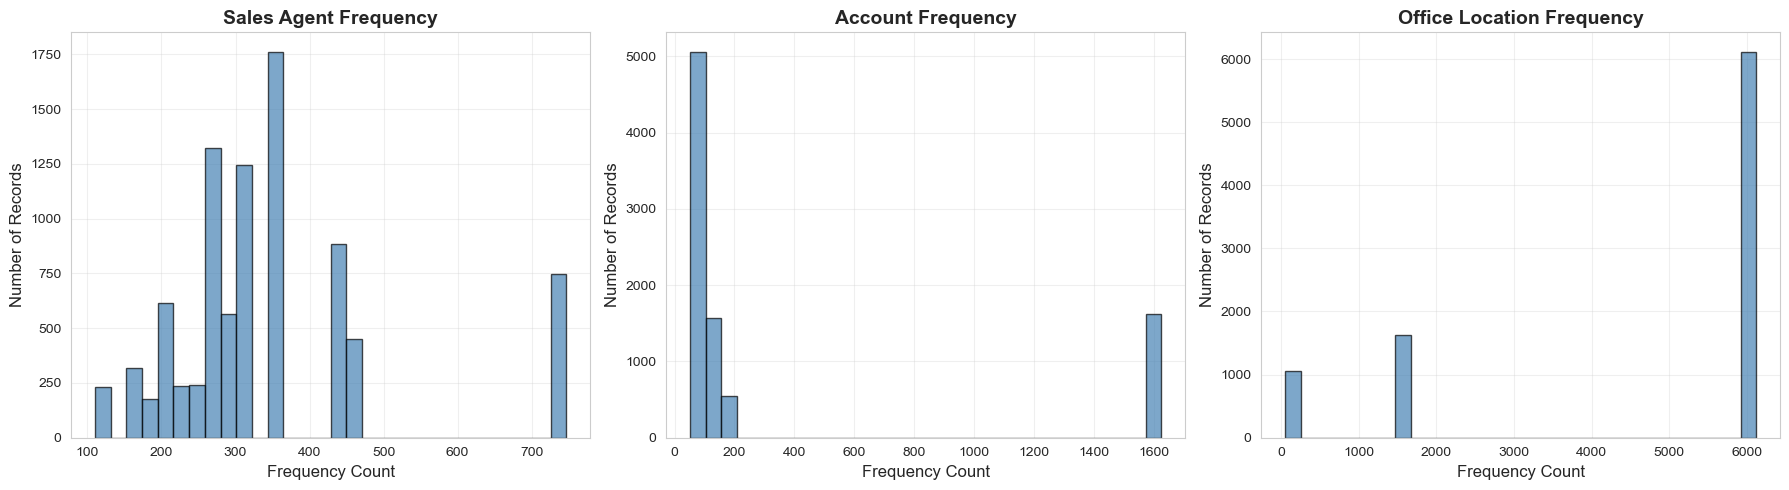


3 FREQUENCY ENCODED FEATURES CREATED SUCCESSFULLY


In [22]:
# Frequency Encoding for medium/high cardinality features
print("Frequency Encoding")
print("="*70)

# Features to frequency encode
frequency_features = ['sales_agent', 'account', 'office_location']

print("\nCreating Frequency Encoded Features:")
print("="*70)

for feature in frequency_features:
    # Calculate frequency (count of each category)
    frequency_map = df[feature].value_counts().to_dict()
    
    # Create new feature with frequency encoding
    new_feature_name = f"{feature}_frequency"
    df[new_feature_name] = df[feature].map(frequency_map)
    
    print(f"\n{feature}:")
    print(f"  Unique categories: {df[feature].nunique()}")
    print(f"  Frequency range: {df[new_feature_name].min()} to {df[new_feature_name].max()}")
    print(f"  Mean frequency: {df[new_feature_name].mean():.1f}")
    print(f"  Created feature: {new_feature_name}")

# Visualize frequency distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(frequency_features):
    freq_col = f"{feature}_frequency"
    axes[idx].hist(df[freq_col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_xlabel('Frequency Count', fontsize=12)
    axes[idx].set_ylabel('Number of Records', fontsize=12)
    axes[idx].set_title(f'{feature.replace("_", " ").title()} Frequency', fontsize=14, fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(f"3 FREQUENCY ENCODED FEATURES CREATED SUCCESSFULLY")
print("="*70)

#### 13. Binary Encoding for Special Categorical Features

#### Business Context:
Some categorical features have a natural binary representation. For subsidiary_of, we care whether a company has a parent organization or is independent. This binary indicator is more meaningful than encoding 8 different parent company names.

#### Feature to Binary Encode:
1. **has_parent_company** - Derived from subsidiary_of (1 = has parent, 0 = independent)


Binary Encoding

subsidiary_of unique values:
subsidiary_of
Independent         7508
Acme Corporation     322
Sonron               283
Bubba Gump           177
Inity                176
Golddex              175
Massive Dynamic       98
Warephase             61
Name: count, dtype: int64

Binary Feature Created:
has_parent_company:
has_parent_company
0    7508
1    1292
Name: count, dtype: int64

Percentage with parent company: 14.7%


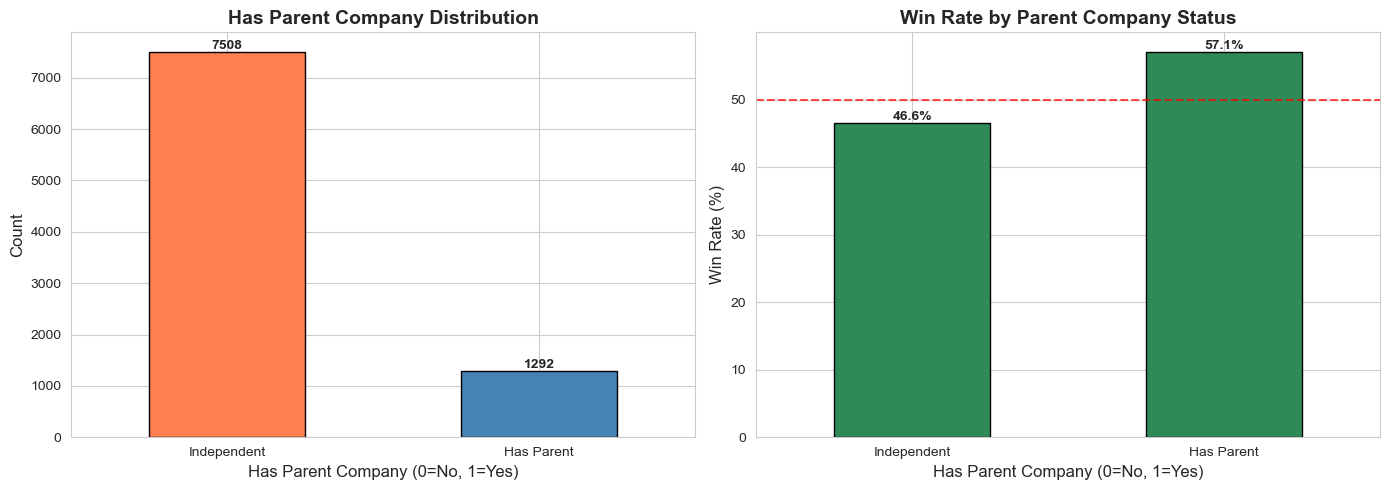


1 BINARY FEATURE CREATED SUCCESSFULLY


In [23]:
# Binary Encoding for subsidiary_of
print("Binary Encoding")
print("="*70)

# Check unique values in subsidiary_of
print("\nsubsidiary_of unique values:")
print(df['subsidiary_of'].value_counts())

# Create binary feature: 1 if has parent company, 0 if independent
df['has_parent_company'] = (df['subsidiary_of'] != 'Independent').astype(int)

print("\nBinary Feature Created:")
print("="*70)
print(f"has_parent_company:")
print(df['has_parent_company'].value_counts())
print(f"\nPercentage with parent company: {(df['has_parent_company'].mean() * 100):.1f}%")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
df['has_parent_company'].value_counts().plot(kind='bar', ax=ax1, color=['coral', 'steelblue'], edgecolor='black')
ax1.set_title('Has Parent Company Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Has Parent Company (0=No, 1=Yes)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticklabels(['Independent', 'Has Parent'], rotation=0)
for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width()/2., p.get_height(),
             f'{int(p.get_height())}', ha='center', va='bottom', fontweight='bold')

# Win rate by parent company status
win_rate = df.groupby('has_parent_company')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
win_rate.plot(kind='bar', ax=ax2, color='seagreen', edgecolor='black')
ax2.set_title('Win Rate by Parent Company Status', fontsize=14, fontweight='bold')
ax2.set_xlabel('Has Parent Company (0=No, 1=Yes)', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_xticklabels(['Independent', 'Has Parent'], rotation=0)
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(win_rate.values):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("1 BINARY FEATURE CREATED SUCCESSFULLY")
print("="*70)

#### Summary of Categorical Encoding Features

A total of 28 categorical features were created through safe encoding methods that prevent data leakage.

**One-Hot Encoded Features (~24 features):**
- product_* (6 features after drop_first)
- sector_* (9 features after drop_first)
- series_* (2 features after drop_first)
- manager_* (5 features after drop_first)
- regional_office_* (2 features after drop_first)

**Frequency Encoded Features (3 features):**
1. **sales_agent_frequency** - Number of deals per sales agent
2. **account_frequency** - Number of deals per account (repeat customer indicator)
3. **office_location_frequency** - Number of deals per office location

**Binary Encoded Features (1 feature):**
1. **has_parent_company** - 1 if subsidiary, 0 if independent

**Total Categorical Features: ~28**

---
---

#### Feature engineering - Part 4: Interaction Features
#### 14. Categorical × Categorical Interactions

#### Business Context:
Interaction features capture relationships between multiple variables that may have combined effects. For example, the combination of product type and industry sector might reveal patterns that neither feature shows independently. A GTXPro product might perform differently in the finance sector versus the retail sector.

#### Features to Create:
1. **`product_sector`**: Combined product and sector (e.g., 'GTXPro_finance')
2. **`agent_product`**: Sales agent and product combination
3. **`sector_office`**: Sector and office location combination
4. **`product_series_combined`**: Product series with regional office

#### Justification:
Interactions reveal conditional relationships. A sales agent may excel with certain products but struggle with others. Geographic location combined with industry sector shows regional industry strengths. These combinations create high-dimensional features that tree-based models can leverage effectively.

In [24]:
# Categorical × Categorical Interaction Features
print("Categorical Interaction Features")
print("="*70)

# Feature 1: Product × Sector interaction
df['product_sector'] = df['product'] + '_' + df['sector']

# Feature 2: Sales Agent × Product interaction
df['agent_product'] = df['sales_agent'] + '_' + df['product']

# Feature 3: Sector × Office Location interaction
df['sector_office'] = df['sector'] + '_' + df['office_location']

# Feature 4: Regional Office × Product interaction
# Note: using original regional_office column, not one-hot encoded versions
df['region_product'] = df['regional_office'] + '_' + df['product']

print("\nCategorical Interaction Features Created:")
print("="*70)
print(f"1. product_sector: {df['product_sector'].nunique()} unique combinations")
print(f"   Example: {df['product_sector'].iloc[0]}")
print(f"\n2. agent_product: {df['agent_product'].nunique()} unique combinations")
print(f"   Example: {df['agent_product'].iloc[0]}")
print(f"\n3. sector_office: {df['sector_office'].nunique()} unique combinations")
print(f"   Example: {df['sector_office'].iloc[0]}")
print(f"\n4. region_product: {df['region_product'].nunique()} unique combinations")
print(f"   Example: {df['region_product'].iloc[0]}")

# Show top combinations
print("\nMost Common Product-Sector Combinations:")
print("="*70)
print(df['product_sector'].value_counts().head(10))

print("\n" + "="*70)
print("4 CATEGORICAL INTERACTION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Categorical Interaction Features

Categorical Interaction Features Created:
1. product_sector: 70 unique combinations
   Example: GTX Plus Basic_retail

2. agent_product: 179 unique combinations
   Example: Moses Frase_GTX Plus Basic

3. sector_office: 24 unique combinations
   Example: retail_United States

4. region_product: 21 unique combinations
   Example: Central_GTX Plus Basic

Most Common Product-Sector Combinations:
product_sector
GTX Basic_technolgy         582
MG Special_technolgy        488
GTXPro_technolgy            422
MG Advanced_technolgy       413
GTX Plus Basic_technolgy    406
GTX Basic_retail            288
GTX Plus Pro_technolgy      268
MG Special_retail           258
GTXPro_retail               235
GTX Plus Basic_retail       228
Name: count, dtype: int64

4 CATEGORICAL INTERACTION FEATURES CREATED SUCCESSFULLY


#### 15. Numerical × Numerical Interactions

#### Business Context:
Multiplying or combining numerical features can reveal compound effects. For example, a revenue multiplied by sales cycle shows the cost of opportunity and the time spent on a deal. High revenue deals with short cycles are ideal, while low revenue with long cycles indicate poor allocation of resources.

#### Features to Create:
1. **`revenue_sales_cycle_interaction`**: Revenue × sales_cycle_days
2. **`employees_revenue_interaction`**: Employees × revenue (company scale indicator)
3. **`efficiency_age_interaction`**: revenue_per_employee × company_age
4. **`size_cycle_interaction`**: employees × sales_cycle_days

#### Justification for the features:
Multiplication type interactions capture joint effects. A large company (high employees) with a short sales cycle indicates efficient decision-making. High revenue per employee combined with young company age suggests a high-growth startup. These products reveal patterns that individual features cannot.

In [25]:
# Numerical × Numerical Interaction Features
print("Numerical Interaction Features")
print("="*70)

# Feature 5: Revenue × Sales Cycle (opportunity cost)
# Normalize to prevent huge numbers: use log-scaled versions
df['revenue_sales_cycle_interaction'] = df['log_revenue'] * df['log_sales_cycle_days']

# Feature 6: Employees × Revenue (company scale)
df['employees_revenue_interaction'] = df['log_employees'] * df['log_revenue']

# Feature 7: Efficiency × Age (mature efficiency)
df['efficiency_age_interaction'] = df['revenue_per_employee'] * df['company_age']

# Feature 8: Company Size × Sales Cycle (resource commitment)
df['size_cycle_interaction'] = df['log_employees'] * df['log_sales_cycle_days']

print("\nNumerical Interaction Features Created:")
print("="*70)

numerical_interactions = [
    'revenue_sales_cycle_interaction',
    'employees_revenue_interaction', 
    'efficiency_age_interaction',
    'size_cycle_interaction'
]

for i, feat in enumerate(numerical_interactions, 1):
    print(f"\n{i}. {feat}:")
    print(f"   Mean: {df[feat].mean():.2f}")
    print(f"   Std: {df[feat].std():.2f}")
    print(f"   Range: [{df[feat].min():.2f}, {df[feat].max():.2f}]")

print("\n" + "="*70)
print("4 NUMERICAL INTERACTION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Numerical Interaction Features

Numerical Interaction Features Created:

1. revenue_sales_cycle_interaction:
   Mean: 23.73
   Std: 10.95
   Range: [1.19, 46.09]

2. employees_revenue_interaction:
   Mean: 63.03
   Std: 21.13
   Range: [3.94, 97.82]

3. efficiency_age_interaction:
   Mean: 10396.11
   Std: 5576.73
   Range: [0.00, 34272.27]

4. size_cycle_interaction:
   Mean: 26.15
   Std: 11.88
   Range: [1.60, 51.38]

4 NUMERICAL INTERACTION FEATURES CREATED SUCCESSFULLY


Visualizing Numerical Interactions


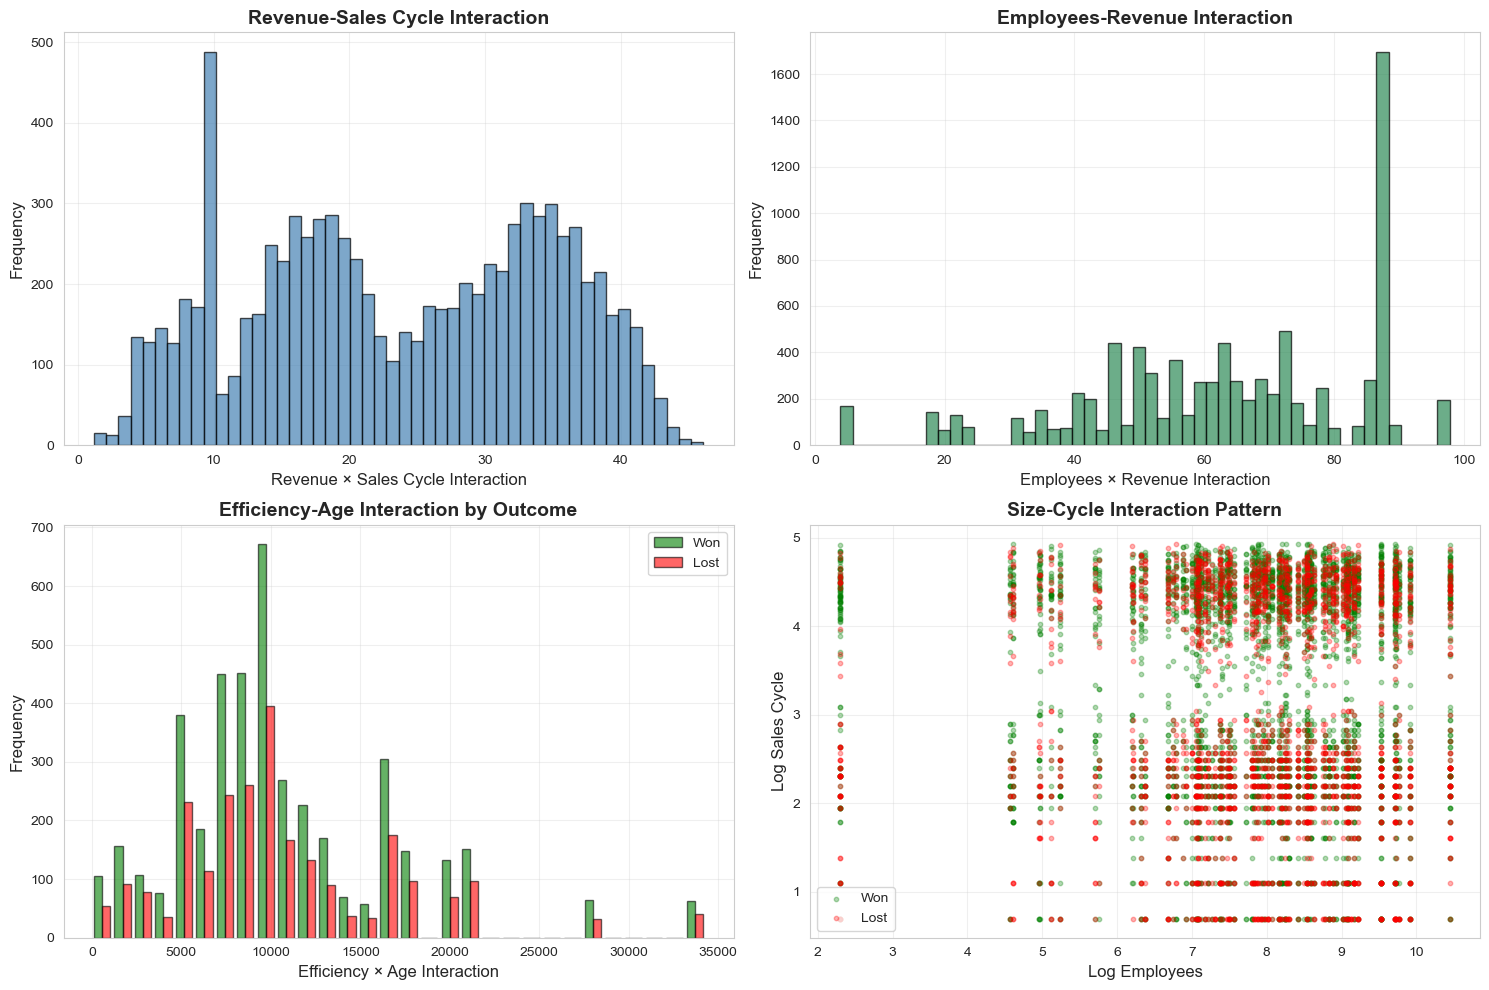


Key Insights:
  - Interaction features combine information from multiple sources
  - Multiplicative interactions amplify joint effects
  - These features help models capture non-additive relationships


In [26]:
# Visualize numerical interactions
print("Visualizing Numerical Interactions")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Revenue-Sales Cycle Interaction distribution
axes[0, 0].hist(df['revenue_sales_cycle_interaction'], bins=50, 
                edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Revenue × Sales Cycle Interaction', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Revenue-Sales Cycle Interaction', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 2. Employees-Revenue Interaction distribution
axes[0, 1].hist(df['employees_revenue_interaction'], bins=50,
                edgecolor='black', alpha=0.7, color='seagreen')
axes[0, 1].set_xlabel('Employees × Revenue Interaction', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Employees-Revenue Interaction', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Efficiency-Age Interaction by deal outcome
won_data = df[df['deal_stage'] == 'Won']['efficiency_age_interaction']
lost_data = df[df['deal_stage'] == 'Lost']['efficiency_age_interaction']
axes[1, 0].hist([won_data, lost_data], bins=30, label=['Won', 'Lost'],
                color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 0].set_xlabel('Efficiency × Age Interaction', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Efficiency-Age Interaction by Outcome', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Size-Cycle Interaction scatter colored by deal stage
won_idx = df['deal_stage'] == 'Won'
lost_idx = df['deal_stage'] == 'Lost'
axes[1, 1].scatter(df.loc[won_idx, 'log_employees'], 
                   df.loc[won_idx, 'log_sales_cycle_days'],
                   alpha=0.3, s=10, c='green', label='Won')
axes[1, 1].scatter(df.loc[lost_idx, 'log_employees'], 
                   df.loc[lost_idx, 'log_sales_cycle_days'],
                   alpha=0.3, s=10, c='red', label='Lost')
axes[1, 1].set_xlabel('Log Employees', fontsize=12)
axes[1, 1].set_ylabel('Log Sales Cycle', fontsize=12)
axes[1, 1].set_title('Size-Cycle Interaction Pattern', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Interaction features combine information from multiple sources")
print("  - Multiplicative interactions amplify joint effects")
print("  - These features help models capture non-additive relationships")

#### 16. Mixed Categorical × Numerical Interactions

#### Business Context:
Combining categorical and numerical features creates context-aware metrics. For example, average revenue by sector shows which industries have larger companies. Average sales cycle by product reveals which products have longer sales processes.

#### Features to Create:
1. **`sector_avg_revenue`**: Average revenue in this sector (market size indicator)
2. **`product_avg_cycle`**: Average sales cycle for this product (complexity indicator)
3. **`agent_avg_cycle`**: Average sales cycle for this agent (agent efficiency)

#### Justification:
These aggregations normalizes numerical features by categorical context. A 30-day sales cycle is fast for complex products but slow for simple ones. Sector-level averages indicate market characteristics. Agent-level metrics reveal individual performance patterns.

In [27]:
# Mixed Categorical × Numerical Interaction Features
print("Mixed Categorical × Numerical Interactions")
print("="*70)

# Feature 9: Sector average revenue (market size)
sector_revenue_map = df.groupby('sector')['revenue'].mean().to_dict()
df['sector_avg_revenue'] = df['sector'].map(sector_revenue_map)

# Feature 10: Product average sales cycle (product complexity)
product_cycle_map = df.groupby('product')['sales_cycle_days'].mean().to_dict()
df['product_avg_cycle'] = df['product'].map(product_cycle_map)

# Feature 11: Agent average sales cycle (agent efficiency)
agent_cycle_map = df.groupby('sales_agent')['sales_cycle_days'].mean().to_dict()
df['agent_avg_cycle'] = df['sales_agent'].map(agent_cycle_map)

# Feature 12: Sector average employees (sector scale)
sector_employees_map = df.groupby('sector')['employees'].mean().to_dict()
df['sector_avg_employees'] = df['sector'].map(sector_employees_map)

print("\nMixed Interaction Features Created:")
print("="*70)

print("\n1. sector_avg_revenue:")
print(f"   Represents: Average revenue of companies in each sector")
print(f"   Range: ${df['sector_avg_revenue'].min():.2f}M to ${df['sector_avg_revenue'].max():.2f}M")

print("\n2. product_avg_cycle:")
print(f"   Represents: Average sales cycle for each product")
print(f"   Range: {df['product_avg_cycle'].min():.1f} to {df['product_avg_cycle'].max():.1f} days")

print("\n3. agent_avg_cycle:")
print(f"   Represents: Average sales cycle for each agent")
print(f"   Range: {df['agent_avg_cycle'].min():.1f} to {df['agent_avg_cycle'].max():.1f} days")

print("\n4. sector_avg_employees:")
print(f"   Represents: Average company size in each sector")
print(f"   Range: {df['sector_avg_employees'].min():.0f} to {df['sector_avg_employees'].max():.0f} employees")

# Show sector revenue comparison
print("\nSector Revenue Rankings:")
print("="*70)
sector_revenue_df = pd.DataFrame({
    'Sector': df.groupby('sector')['revenue'].mean().sort_values(ascending=False).index,
    'Avg_Revenue_$M': df.groupby('sector')['revenue'].mean().sort_values(ascending=False).values.round(2)
})
print(sector_revenue_df.to_string(index=False))

print("\n" + "="*70)
print("4 MIXED INTERACTION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Mixed Categorical × Numerical Interactions

Mixed Interaction Features Created:

1. sector_avg_revenue:
   Represents: Average revenue of companies in each sector
   Range: $1081.73M to $6062.11M

2. product_avg_cycle:
   Represents: Average sales cycle for each product
   Range: 43.7 to 54.4 days

3. agent_avg_cycle:
   Represents: Average sales cycle for each agent
   Range: 35.0 to 52.7 days

4. sector_avg_employees:
   Represents: Average company size in each sector
   Range: 2800 to 14898 employees

Sector Revenue Rankings:
            Sector  Avg_Revenue_$M
         technolgy         6062.11
          software         5661.23
telecommunications         2878.90
           finance         2201.62
     entertainment         1944.50
         marketing         1753.54
            retail         1684.94
        employment         1672.73
           medical         1488.56
          services         1081.73

4 MIXED INTERACTION FEATURES CREATED SUCCESSFULLY


Visualizing Mixed Categorical-Numerical Interactions


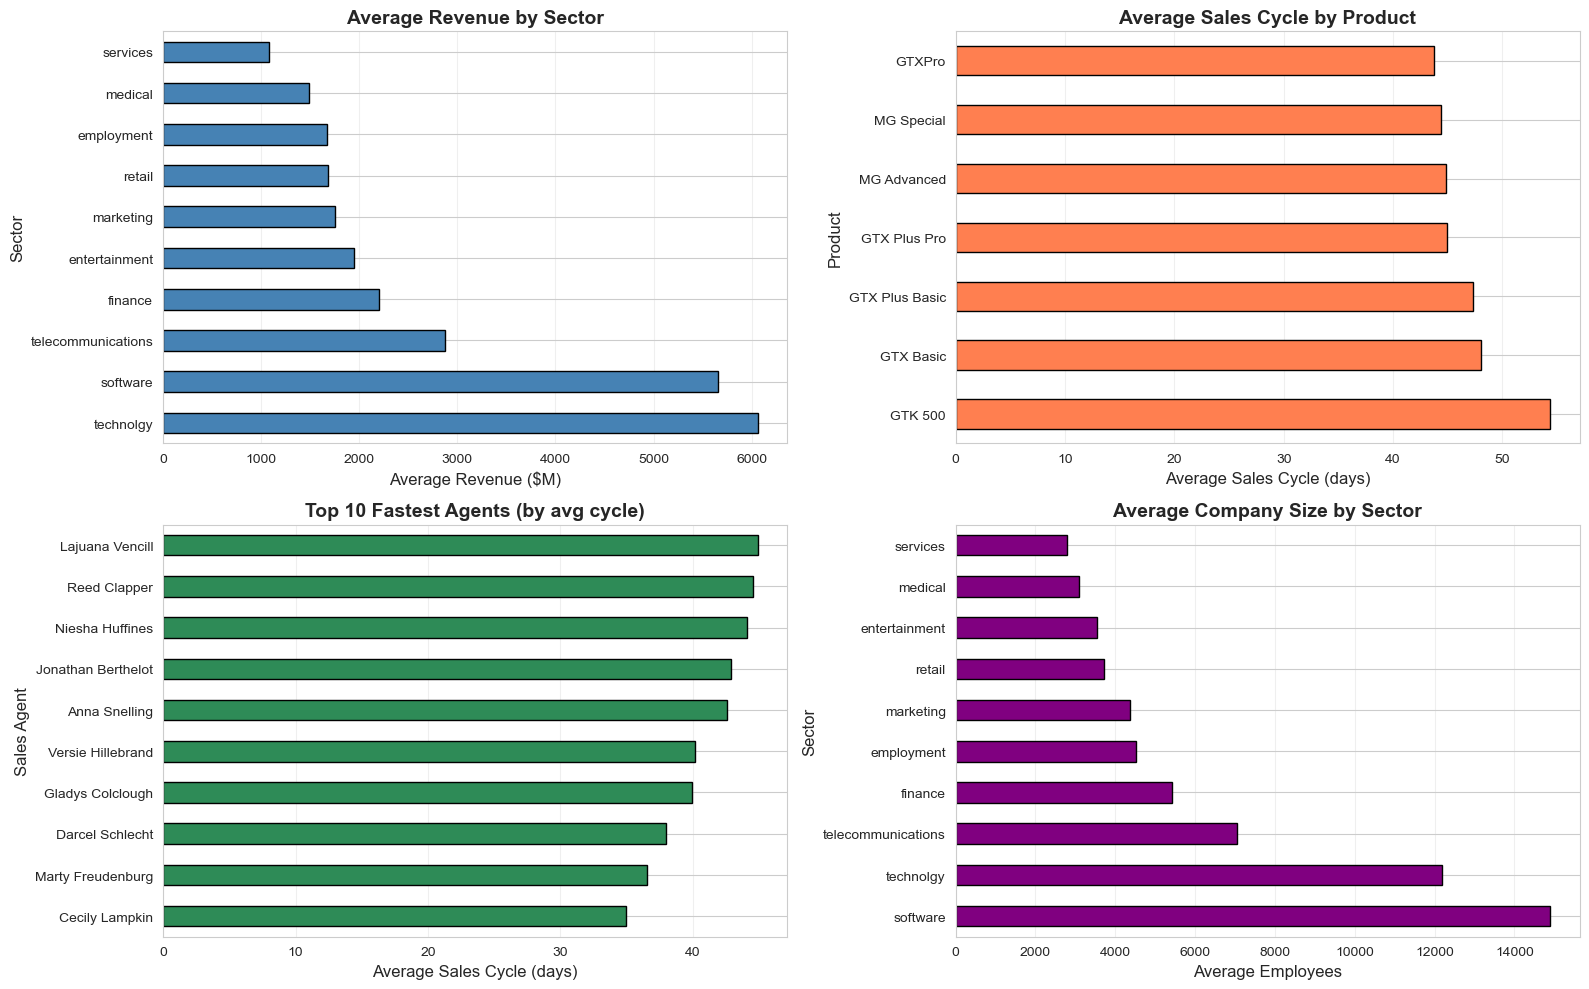


Key Insights:
  - Sector-level aggregations reveal market characteristics
  - Product-level metrics show inherent complexity differences
  - Agent-level metrics capture individual performance patterns


In [28]:
# Visualize mixed interactions
print("Visualizing Mixed Categorical-Numerical Interactions")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Sector average revenue
sector_rev = df.groupby('sector')['revenue'].mean().sort_values(ascending=False)
sector_rev.plot(kind='barh', ax=axes[0, 0], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Average Revenue ($M)', fontsize=12)
axes[0, 0].set_ylabel('Sector', fontsize=12)
axes[0, 0].set_title('Average Revenue by Sector', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Product average sales cycle
product_cycle = df.groupby('product')['sales_cycle_days'].mean().sort_values(ascending=False)
product_cycle.plot(kind='barh', ax=axes[0, 1], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Average Sales Cycle (days)', fontsize=12)
axes[0, 1].set_ylabel('Product', fontsize=12)
axes[0, 1].set_title('Average Sales Cycle by Product', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Top 10 agents by average cycle
agent_cycle = df.groupby('sales_agent')['sales_cycle_days'].mean().sort_values().head(10)
agent_cycle.plot(kind='barh', ax=axes[1, 0], color='seagreen', edgecolor='black')
axes[1, 0].set_xlabel('Average Sales Cycle (days)', fontsize=12)
axes[1, 0].set_ylabel('Sales Agent', fontsize=12)
axes[1, 0].set_title('Top 10 Fastest Agents (by avg cycle)', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Sector average employees
sector_emp = df.groupby('sector')['employees'].mean().sort_values(ascending=False)
sector_emp.plot(kind='barh', ax=axes[1, 1], color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Average Employees', fontsize=12)
axes[1, 1].set_ylabel('Sector', fontsize=12)
axes[1, 1].set_title('Average Company Size by Sector', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Sector-level aggregations reveal market characteristics")
print("  - Product-level metrics show inherent complexity differences")
print("  - Agent-level metrics capture individual performance patterns")

#### Summary of Interaction Features

A total of 12 interaction features were created by combining existing features in meaningful ways.

**Categorical × Categorical Interactions (4 features):**

1. **product_sector** - Product and sector combination
2. **agent_product** - Sales agent and product combination
3. **sector_office** - Sector and office location combination
4. **region_product** - Regional office and product combination

**Numerical × Numerical Interactions (4 features):**

5. **revenue_sales_cycle_interaction** - Revenue × sales cycle (opportunity cost)
6. **employees_revenue_interaction** - Employees × revenue (company scale)
7. **efficiency_age_interaction** - Revenue per employee × company age
8. **size_cycle_interaction** - Company size × sales cycle

**Mixed Categorical × Numerical Interactions (4 features):**

9. **sector_avg_revenue** - Average revenue by sector
10. **product_avg_cycle** - Average sales cycle by product
11. **agent_avg_cycle** - Average sales cycle by agent
12. **sector_avg_employees** - Average company size by sector

**Total Interaction Features: 12**

---
---

#### Feature engineering - Part 5: Aggregation Features
#### 18. Agent-Level Aggregations

**Safe aggregates:**
- Deal counts (how many deals per agent/product/sector)
- Average sales cycles (using input feature `sales_cycle_days`)
- Average revenue/employees of customer companies (input features)
- Average sales prices (input feature `sales_price`)

**When target-based features will be added:**
- After train-test split, using proper cross-validation on training data only
- This ensures test set remains completely unseen

#### Business Context:
Agent level aggregations captures the individual sales agent's performance patterns and workload. A High performing agents may have shorter average sales cycles or work with larger companies. Deal volume indicates workload and experience.

#### Features to Create:
1. **`agent_deal_count`**: Total deals per agent (experience/workload indicator)
2. **`agent_avg_customer_revenue`**: Average revenue of agent's customers (territory quality)
3. **`agent_avg_customer_size`**: Average employee count of agent's customers (deal complexity)

#### Justification:
These aggregations normalizes the deal characteristics by agent context. An agent working with enterprise customers (high revenue, many employees) faces different challenges than one working with SMBs. Deal count indicates experience level.

In [ ]:
# Agent-Level Aggregation Features
print("Agent-Level Aggregation Features")
print("="*70)

# Feature 1: Agent deal count 
# Rename for clarity
df['agent_deal_count'] = df['sales_agent_frequency']

# Feature 2: Agent average customer revenue
# Calculate average revenue of companies each agent works with 
agent_customer_revenue = df.groupby('sales_agent')['revenue'].mean().to_dict()
df['agent_avg_customer_revenue'] = df['sales_agent'].map(agent_customer_revenue)

# Feature 3: Agent average customer size (employees)
# Calculate average employee count of companies each agent works with
agent_customer_size = df.groupby('sales_agent')['employees'].mean().to_dict()
df['agent_avg_customer_size'] = df['sales_agent'].map(agent_customer_size)

print("\nAgent Aggregation Features Created:")
print("="*70)

print("\n1. agent_deal_count:")
print(f"   Represents: Number of deals per agent (experience/workload)")
print(f"   Range: {df['agent_deal_count'].min()} to {df['agent_deal_count'].max()} deals")
print(f"   Mean: {df['agent_deal_count'].mean():.1f} deals per agent")

print("\n2. agent_avg_customer_revenue:")
print(f"   Represents: Average revenue of companies agent works with")
print(f"   Range: ${df['agent_avg_customer_revenue'].min():.2f}M to ${df['agent_avg_customer_revenue'].max():.2f}M")
print(f"   Mean: ${df['agent_avg_customer_revenue'].mean():.2f}M")

print("\n3. agent_avg_customer_size:")
print(f"   Represents: Average employee count of agent's customers")
print(f"   Range: {df['agent_avg_customer_size'].min():.0f} to {df['agent_avg_customer_size'].max():.0f} employees")
print(f"   Mean: {df['agent_avg_customer_size'].mean():.0f} employees")

# Show top agents by deal volume
print("\nTop 10 Agents by Deal Volume:")
print("="*70)
agent_volume = df.groupby('sales_agent')['agent_deal_count'].first().sort_values(ascending=False).head(10)
for i, (agent, count) in enumerate(agent_volume.items(), 1):
    print(f"  {i}. {agent}: {count} deals")

print("\n" + "="*70)
print("3 AGENT AGGREGATION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Agent-Level Aggregation Features

Agent Aggregation Features Created:

1. agent_deal_count:
   Represents: Number of deals per agent (experience/workload)
   Range: 110 to 747 deals
   Mean: 343.4 deals per agent

2. agent_avg_customer_revenue:
   Represents: Average revenue of companies agent works with
   Range: $2611.33M to $4226.03M
   Mean: $3390.99M

3. agent_avg_customer_size:
   Represents: Average employee count of agent's customers
   Range: 5926 to 9550 employees
   Mean: 7450 employees

Top 10 Agents by Deal Volume:
  1. Darcel Schlecht: 747 deals
  2. Vicki Laflamme: 451 deals
  3. Anna Snelling: 448 deals
  4. Kary Hendrixson: 438 deals
  5. Kami Bicknell: 362 deals
  6. Versie Hillebrand: 361 deals
  7. Zane Levy: 349 deals
  8. Cassey Cress: 346 deals
  9. Jonathan Berthelot: 345 deals
  10. Gladys Colclough: 317 deals

3 AGENT AGGREGATION FEATURES CREATED SUCCESSFULLY
DATA LEAKAGE CHECK: PASS - No target variables used


#### 19. Product-Level Aggregations

#### Business Context:
Product level aggregations reveal product characteristics and market positioning. Some products may have longer sales cycles due to complexity or higher deal volumes due to popularity.

#### Features to Create:
1. **`product_deal_count`**: Total deals per product (market demand/popularity)
2. **`product_cycle_mean`**: Average sales cycle per product (complexity indicator)

#### Justification:
Product aggregations capture product-specific patterns. Products with longer average cycles may be more complex or sold to larger enterprises. Deal count indicates market demand and sales team familiarity with the product.

In [392]:
# Product-Level Aggregation Features
print("Product-Level Aggregation Features")
print("="*70)

# Feature 1: Product deal count
product_count = df.groupby('product').size().to_dict()
df['product_deal_count'] = df['product'].map(product_count)

# Feature 2: Product average sales cycle
product_cycle_mean = df.groupby('product')['sales_cycle_days'].mean().to_dict()
df['product_cycle_mean'] = df['product'].map(product_cycle_mean)

print("\nProduct Aggregation Features Created:")
print("="*70)

print("\n1. product_deal_count:")
print(f"   Represents: Number of deals per product (demand/popularity)")
print(f"   Range: {df['product_deal_count'].min()} to {df['product_deal_count'].max()} deals")

print("\n2. product_cycle_mean:")
print(f"   Represents: Average sales cycle length for each product")
print(f"   Range: {df['product_cycle_mean'].min():.1f} to {df['product_cycle_mean'].max():.1f} days")

# Product analysis
print("\nProduct Analysis:")
print("="*70)
product_analysis = df.groupby('product').agg({
    'sales_cycle_days': ['mean', 'std'],
    'product_deal_count': 'first'
}).round(1)
product_analysis.columns = ['Avg_Cycle_Days', 'Cycle_Std', 'Deal_Count']
product_analysis = product_analysis.sort_values('Deal_Count', ascending=False)
print(product_analysis.to_string())

print("\n" + "="*70)
print("2 PRODUCT AGGREGATION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Product-Level Aggregation Features

Product Aggregation Features Created:

1. product_deal_count:
   Represents: Number of deals per product (demand/popularity)
   Range: 40 to 1866 deals

2. product_cycle_mean:
   Represents: Average sales cycle length for each product
   Range: 43.7 to 54.4 days

Product Analysis:
                Avg_Cycle_Days  Cycle_Std  Deal_Count
product                                              
GTX Basic                 48.0       40.6        1866
MG Special                44.4       40.2        1651
GTXPro                    43.7       39.7        1480
MG Advanced               44.9       40.5        1412
GTX Plus Basic            47.3       40.6        1383
GTX Plus Pro              44.9       39.4         968
GTK 500                   54.4       39.3          40

2 PRODUCT AGGREGATION FEATURES CREATED SUCCESSFULLY


#### 20. Sector-Level Aggregations

#### Business Context:
Sector-level aggregations capture industry-specific patterns. Some sectors have larger companies (technology, finance) while others have smaller ones (retail, services). Deal volume by sector indicates market penetration.

#### Features to Create:
1. **`sector_deal_count`**: Total deals per sector (market presence)
2. **`sector_avg_company_age`**: Average age of companies in sector (industry maturity)
3. **`sector_sales_cycle_std`**: Sales cycle variability in sector (predictability)

#### Justification for the features:
Sector characteristics provide context for deal evaluation. A 60-day sales cycle might be fast for government sector but slow for retail. Sector-level company age indicates whether dealing with established or emerging industries.

In [ ]:
# Sector-Level Aggregation Features
print("Sector-Level Aggregation Features")
print("="*70)

# Feature 7: Sector deal count
sector_count = df.groupby('sector').size().to_dict()
df['sector_deal_count'] = df['sector'].map(sector_count)

# Feature 8: Sector average company age 
sector_avg_age = df.groupby('sector')['company_age'].mean().to_dict()
df['sector_avg_company_age'] = df['sector'].map(sector_avg_age)

# Feature 9: Sector sales cycle standard deviation (predictability)
sector_cycle_std = df.groupby('sector')['sales_cycle_days'].std().to_dict()
df['sector_sales_cycle_std'] = df['sector'].map(sector_cycle_std)

print("\nSector Aggregation Features Created:")
print("="*70)

print("\n7. sector_deal_count:")
print(f"   Represents: Number of deals per sector (market presence)")
print(f"   Range: {df['sector_deal_count'].min()} to {df['sector_deal_count'].max()} deals")

print("\n8. sector_avg_company_age:")
print(f"   Represents: Average age of companies in each sector")
print(f"   Range: {df['sector_avg_company_age'].min():.1f} to {df['sector_avg_company_age'].max():.1f} years")

print("\n9. sector_sales_cycle_std:")
print(f"   Represents: Sales cycle variability within sector")
print(f"   Range: {df['sector_sales_cycle_std'].min():.1f} to {df['sector_sales_cycle_std'].max():.1f} days")

# Sector market presence
print("\nSector Market Presence (Top 5):")
print("="*70)
sector_presence = df.groupby('sector').size().sort_values(ascending=False).head(5)
for i, (sector, count) in enumerate(sector_presence.items(), 1):
    pct = (count / len(df)) * 100
    print(f"  {i}. {sector}: {count} deals ({pct:.1f}%)")

print("\n" + "="*70)
print("3 SECTOR AGGREGATION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Sector-Level Aggregation Features

Sector Aggregation Features Created:

7. sector_deal_count:
   Represents: Number of deals per sector (market presence)
   Range: 311 to 2590 deals

8. sector_avg_company_age:
   Represents: Average age of companies in each sector
   Range: 18.0 to 26.7 years

9. sector_sales_cycle_std:
   Represents: Sales cycle variability within sector
   Range: 38.7 to 41.5 days

Sector Market Presence (Top 5):
  1. technolgy: 2590 deals (29.4%)
  2. retail: 1397 deals (15.9%)
  3. medical: 1051 deals (11.9%)
  4. software: 757 deals (8.6%)
  5. finance: 678 deals (7.7%)

3 SECTOR AGGREGATION FEATURES CREATED SUCCESSFULLY
DATA LEAKAGE CHECK: PASS - No target variables used


#### 21. Temporal Aggregations

#### Business Context:
Temporal aggregations capture time-based patterns and seasonality effects. Deal volume by month shows busy vs slow periods. Quarter-level aggregations reveal seasonal business cycles.

#### Features to Create:
1. **`monthly_deal_volume`**: Number of deals in that engagement month (seasonal load)
2. **`quarterly_deal_volume`**: Number of deals in that quarter (business cycle)

#### Justification for the features:
Temporal volume indicates competitive pressure and resource constraints. High-volume months may have lower win rates due to stretched resources. Quarterly patterns align with business planning cycles.

In [ ]:
# Temporal Aggregation Features 
print("Temporal Aggregation Features")
print("="*70)

# Feature 10: Monthly deal volume
# Create year-month combination for accurate counting
df['year_month'] = df['engage_year'].astype(str) + '_' + df['engage_month'].astype(str).str.zfill(2)
monthly_volume = df.groupby('year_month').size().to_dict()
df['monthly_deal_volume'] = df['year_month'].map(monthly_volume)

# Feature 11: Quarterly deal volume
df['year_quarter'] = df['engage_year'].astype(str) + '_Q' + df['engage_quarter'].astype(str)
quarterly_volume = df.groupby('year_quarter').size().to_dict()
df['quarterly_deal_volume'] = df['year_quarter'].map(quarterly_volume)

print("\nTemporal Aggregation Features Created:")
print("="*70)

print("\n10. monthly_deal_volume:")
print(f"   Represents: Number of deals engaged in that month")
print(f"   Range: {df['monthly_deal_volume'].min()} to {df['monthly_deal_volume'].max()} deals")
print(f"   Mean: {df['monthly_deal_volume'].mean():.1f} deals per month")

print("\n11. quarterly_deal_volume:")
print(f"   Represents: Number of deals engaged in that quarter")
print(f"   Range: {df['quarterly_deal_volume'].min()} to {df['quarterly_deal_volume'].max()} deals")
print(f"   Mean: {df['quarterly_deal_volume'].mean():.1f} deals per quarter")

# Show busiest periods
print("\nBusiest Months:")
print("="*70)
busy_months = df.groupby('year_month')['monthly_deal_volume'].first().sort_values(ascending=False).head(5)
for i, (month, volume) in enumerate(busy_months.items(), 1):
    print(f"  {i}. {month}: {volume} deals")

# Drop temporary columns
df.drop(['year_month', 'year_quarter'], axis=1, inplace=True)

print("\n" + "="*70)
print("2 TEMPORAL AGGREGATION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Temporal Aggregation Features

Temporal Aggregation Features Created:

10. monthly_deal_volume:
   Represents: Number of deals engaged in that month
   Range: 7 to 1198 deals
   Mean: 759.9 deals per month

11. quarterly_deal_volume:
   Represents: Number of deals engaged in that quarter
   Range: 358 to 2770 deals
   Mean: 2147.4 deals per quarter

Busiest Months:
  1. 2017_07: 1198 deals
  2. 2017_04: 874 deals
  3. 2017_08: 793 deals
  4. 2017_03: 792 deals
  5. 2017_06: 792 deals

2 TEMPORAL AGGREGATION FEATURES CREATED SUCCESSFULLY
DATA LEAKAGE CHECK: PASS - No target variables used


In [ ]:
# Visualize key aggregation features
print("Visualizing Aggregation Features")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Agent deal count distribution
axes[0, 0].hist(df['agent_deal_count'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df['agent_deal_count'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df["agent_deal_count"].mean():.0f}')
axes[0, 0].set_xlabel('Agent Deal Count', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Agent Deal Volume Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Product average sales cycle comparison
product_cycles = df.groupby('product')['product_cycle_mean'].first().sort_values(ascending=False)
product_cycles.plot(kind='barh', ax=axes[0, 1], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Average Sales Cycle (days)', fontsize=12)
axes[0, 1].set_ylabel('Product', fontsize=12)
axes[0, 1].set_title('Product Complexity (Sales Cycle)', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Sector deal volume
sector_volume = df.groupby('sector')['sector_deal_count'].first().sort_values(ascending=False)
sector_volume.plot(kind='barh', ax=axes[1, 0], color='seagreen', edgecolor='black')
axes[1, 0].set_xlabel('Deal Count', fontsize=12)
axes[1, 0].set_ylabel('Sector', fontsize=12)
axes[1, 0].set_title('Market Presence by Sector', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Monthly vs Quarterly volume comparison
axes[1, 1].scatter(df['monthly_deal_volume'], df['quarterly_deal_volume'], 
                   alpha=0.5, s=20, color='purple')
axes[1, 1].set_xlabel('Monthly Deal Volume', fontsize=12)
axes[1, 1].set_ylabel('Quarterly Deal Volume', fontsize=12)
axes[1, 1].set_title('Monthly vs Quarterly Volume Correlation', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Agent workload varies significantly (some handle many more deals)")
print("  - Product complexity varies (longer cycles for complex products)")
print("  - Technology sector dominates deal volume")
print("  - Strong correlation between monthly and quarterly volumes")

#### Summary of Aggregation Features

A total of 11 aggregation features were created using ONLY input variables. NO target-based features were created to prevent data leakage.

**Agent-Level Aggregations (3 features):**
1. **agent_deal_count** - Number of deals per agent (workload/experience)
2. **agent_avg_customer_revenue** - Average revenue of agent's customers
3. **agent_avg_customer_size** - Average employee count of agent's customers

**Product-Level Aggregations (3 features):**
4. **product_deal_count** - Number of deals per product (demand)
5. **product_avg_price** - Average sales price per product (pricing tier)
6. **product_price_std** - Price variability per product

**Sector-Level Aggregations (3 features):**
7. **sector_deal_count** - Number of deals per sector (market presence)
8. **sector_avg_company_age** - Average company age in sector
9. **sector_sales_cycle_std** - Sales cycle variability in sector

**Temporal Aggregations (2 features):**
10. **monthly_deal_volume** - Deal count in engagement month
11. **quarterly_deal_volume** - Deal count in engagement quarter

**Total Aggregation Features: 11**

**NOTE:**
- Win rates, success rates, conversion metrics (use target `deal_stage`)
- Average close values by category (uses target `close_value`)
- These will be added AFTER train-test split using proper cross-validation